In [1]:
import pandas as pd
import numpy as np

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, Subset
from transformers import AutoTokenizer, AutoModel

from sklearn.model_selection import StratifiedKFold, cross_validate
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, make_scorer
from sklearn.pipeline import make_pipeline
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import umap
import networkx as nx

import os
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"
torch.cuda.empty_cache()

/home/ubuntu/PinUI-Test/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Initial Analysis

In [2]:
data = pd.read_csv("./data/PiNUI-human.csv")
data.head()

,seqA,seqB,interaction
0,MKRRASDRGAGETSARAKALGSGISGNNAKRAGPFILGPRLGNSPV...,MAASAARGAAALRRSINQPVAFVRRIPWTAASSQLKEHFAQFGHVR...,1
1,MEAPSGSEPGGDGAGDCAHPDPRAPGAAAPSSGPGPCAAARESERQ...,MKLFHTADWHLGKLVHGVYMTEDQKIVLDQFVQAVEEEKPDAVIIA...,1
2,MDQNSVPEKAQNEADTNNADRFFRSHSSPPHHRPGHSRALHHYELH...,MTHCCSPCCQPTCCRTTCWQPTTVTTCSSTPCCQPSCCVSSCCQPC...,1
3,MFADLDYDIEEDKLGIPTVPGKVTLQKDAQNLIGISIGGGAQYCPC...,MARTLRPSPLCPGGGKAQLSSASLLGAGLLLQPPTPPPLLLLLFPL...,1
4,MAEGNHRKKPLKVLESLGKDFLTGVLDNLVEQNVLNWKEEEKKKYY...,MASADSRRVADGGGAGGTFQPYLDTLRQELQQTDPTLLSVVVAVLA...,1


In [3]:
# Get the sequences
all_proteins = list(set(data['seqA']).union(set(data['seqB'])))
N = len(all_proteins)
N

30263

## Visualization

### 1. Visualizing basic distributions

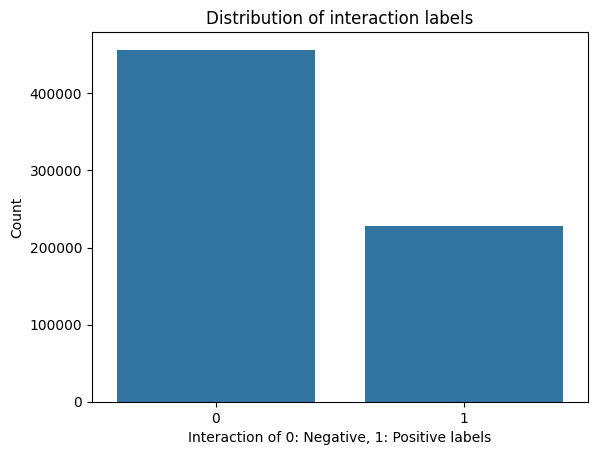

In [4]:
# Count plot for interaction labels
sns.countplot(x='interaction', data=data)
plt.title("Distribution of interaction labels")
plt.xlabel("Interaction of 0: Negative, 1: Positive labels")
plt.ylabel("Count")
plt.show()

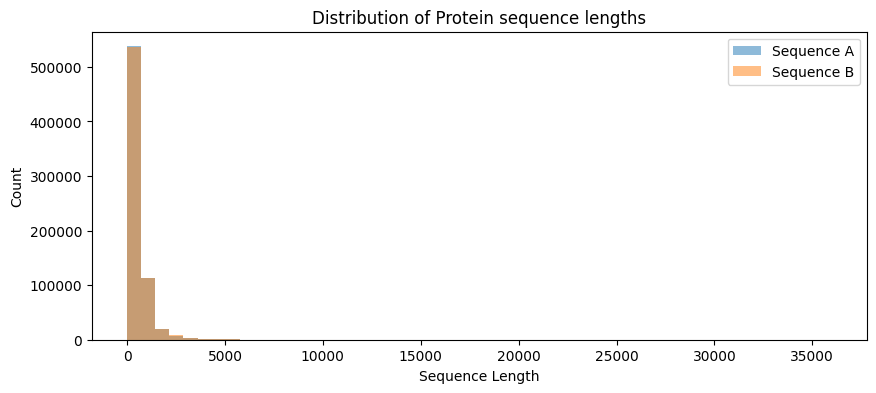

In [5]:
# Sequence length distribution
# Histogram of lenghts of proteins in Sequence-A and Sequence-B

data['seqA_length'] = data['seqA'].apply(len)
data['seqB_length'] = data['seqB'].apply(len)

plt.figure(figsize=(10, 4))
plt.hist(data['seqA_length'], bins=50, alpha=0.5, label='Sequence A')
plt.hist(data['seqB_length'], bins=50, alpha=0.5, label='Sequence B')
plt.title("Distribution of Protein sequence lengths")
plt.xlabel("Sequence Length")
plt.ylabel("Count")
plt.legend()
plt.show()

### 2. Visualize the Embedding Space

In [6]:
TARGET_TOTAL_SAMPLES = 30000
RANDOM_SEED = 42 

data_full = data
print(f"Loaded full dataset with {len(data_full)} rows.")

data_full['interaction'] = data_full['interaction'].astype(int)

data_pos = data_full[data_full['interaction'] == 1]
data_neg = data_full[data_full['interaction'] == 0]
n_pos_available = len(data_pos)
n_neg_available = len(data_neg)
print(f"Available positive samples (interaction=1): {n_pos_available}")
print(f"Available negative samples (interaction=0): {n_neg_available}")

# sample size per class for balancing
target_samples_per_class = TARGET_TOTAL_SAMPLES // 2

# Adjust sample size based on availability
n_samples_per_class = min(n_pos_available, n_neg_available, target_samples_per_class)

print(f"Sampling {n_samples_per_class} from each class.")
final_total_samples = n_samples_per_class * 2
print(f"Total samples in the final balanced dataset will be: {final_total_samples}")

# Perform sampling
data_pos_sampled = data_pos.sample(n=n_samples_per_class, random_state=RANDOM_SEED)
data_neg_sampled = data_neg.sample(n=n_samples_per_class, random_state=RANDOM_SEED)

# Combine the sampled data
data_model = pd.concat([data_pos_sampled, data_neg_sampled])

# Shuffle the combined DataFrame
print("Shuffling the combined dataset...")
data_model = data_model.sample(frac=1, random_state=RANDOM_SEED).reset_index(drop=True)
print(f"Using {len(data_model)} rows.")

Loaded full dataset with 684951 rows.
Available positive samples (interaction=1): 228317
Available negative samples (interaction=0): 456634
Sampling 15000 from each class.
Total samples in the final balanced dataset will be: 30000
Shuffling the combined dataset...
Using 30000 rows.


In [7]:
# Getting the embeddings
tokenizer = AutoTokenizer.from_pretrained("facebook/esm2_t6_8M_UR50D")
esm_model = AutoModel.from_pretrained("facebook/esm2_t6_8M_UR50D")
esm_model.eval()

embeddings_list = []
labels = []

device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)
esm_model.to(device)

N_samples = 20000
for idx, row in data_model.head(N_samples).iterrows():
    # Concatenate the sequences with a delimiter
    pair_input = row['seqA'] + " [SEP] " + row['seqB']
    
    # Tokenize the pair to consistent max_length
    tokens = tokenizer(pair_input, return_tensors="pt", truncation=True, padding='max_length', max_length=1022)
    tokens = {k: v.to(device) for k, v in tokens.items()}
    
    with torch.no_grad():
        outputs = esm_model(**tokens)
    
    # Pool the embeddings using mean pooling across tokens
    # outputs.last_hidden_state has shape (1, sequence_length, hidden_size)
    pooled_embedding = outputs.last_hidden_state.mean(dim=1)  # shape becomes (1, hidden_size)
    
    # Convert to numpy and store
    embeddings_list.append(pooled_embedding.squeeze(0).cpu().numpy())
    labels.append(row['interaction'])

embeddings_array = np.vstack(embeddings_list)
print(f"Shape of embeddigns: {embeddings_array.shape}")

Some weights of EsmModel were not initialized from the model checkpoint at facebook/esm2_t6_8M_UR50D and are newly initialized: ['esm.pooler.dense.bias', 'esm.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


cuda
Shape of embeddigns: (20000, 320)


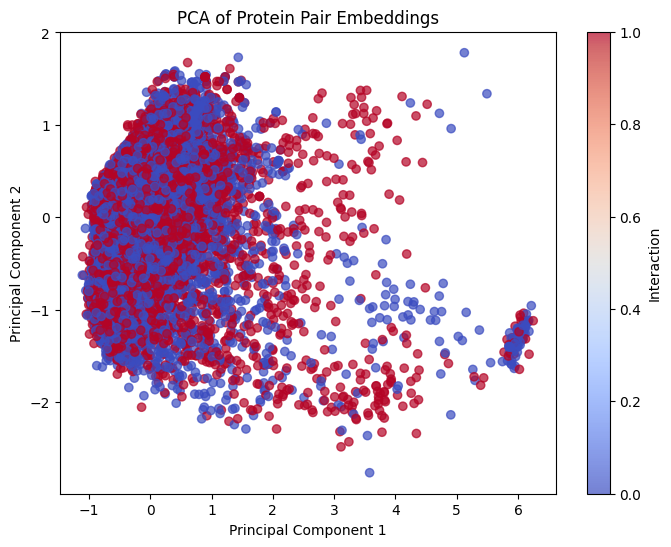

In [8]:
# Dimentionality reduction - PCA
pca = PCA(n_components=2)
embeddings_2d = pca.fit_transform(embeddings_array)

plt.figure(figsize=(8, 6))
plt.scatter(embeddings_2d[:,0], embeddings_2d[:,1], c=labels, cmap="coolwarm", alpha=0.7)
plt.title("PCA of Protein Pair Embeddings")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.colorbar(label="Interaction")
plt.show()

t-SNE shape: (20000, 2)


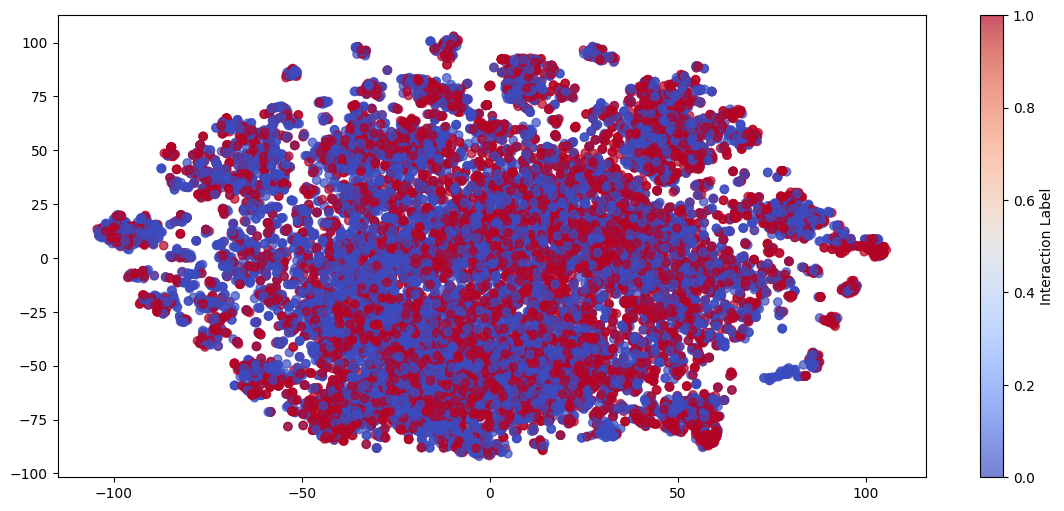

In [9]:
# Dimentionality reduction - tSNE
tsne = TSNE(n_components=2, random_state=42, perplexity=30)
embeddings_tsne = tsne.fit_transform(embeddings_array)
print("t-SNE shape:", embeddings_tsne.shape)

plt.figure(figsize=(14, 6))
plt.scatter(embeddings_tsne[:, 0], embeddings_tsne[:, 1], c=labels, cmap="coolwarm", alpha=0.7)
plt.colorbar(label="Interaction Label")
plt.show()

/home/ubuntu/PinUI-Test/.venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/ubuntu/PinUI-Test/.venv/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


UMAP shape: (20000, 2)


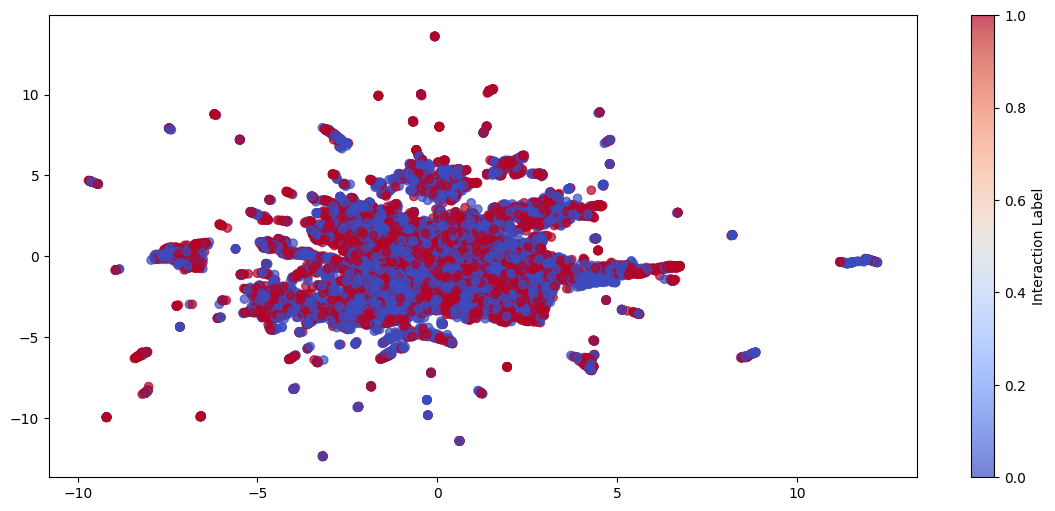

In [10]:
# Dimentionality reduction - UMAP
umap_reducer = umap.UMAP(n_components=2, random_state=42)
embeddings_umap = umap_reducer.fit_transform(embeddings_array)
print("UMAP shape:", embeddings_umap.shape)

plt.figure(figsize=(14, 6))
plt.scatter(embeddings_umap[:, 0], embeddings_umap[:, 1], c=labels, cmap="coolwarm", alpha=0.7)
plt.colorbar(label="Interaction Label")
plt.show()

### 3. Network Visualization

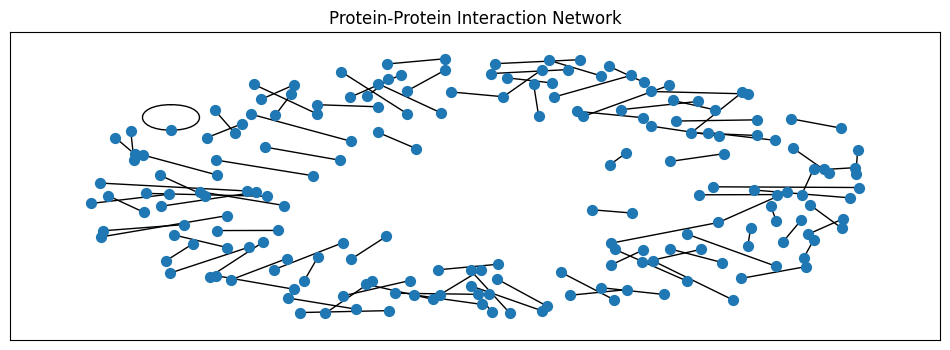

In [11]:
G = nx.from_pandas_edgelist(data[100:200], source='seqA', target='seqB', edge_attr=True)

plt.figure(figsize=(12,4))
pos = nx.spring_layout(G, k=0.15, iterations=20)
nx.draw_networkx(G, pos, node_size=50, font_size=8, with_labels=False)
plt.title("Protein-Protein Interaction Network")
plt.show()

## Implementation

### MLP

In [27]:
# Dataset Class
class PinuiDataset(Dataset):
    def __init__(self, data, esm_model, tokenizer, device='cpu', batch_size=32, max_length=1022):
        self.seqA = list(data['seqA'])
        self.seqB = list(data['seqB'])
        self.interactions = list(data['interaction'])
        self.embeddings = []
        self.labels = []
        self.device = device

        esm_model.to(device)
        esm_model.eval()

        print("Generating embeddings in batches...")
        num_pairs = len(self.seqA)
        with torch.no_grad():
            for i in tqdm(range(0, num_pairs, batch_size)):
                batch_seqA = self.seqA[i:min(i + batch_size, num_pairs)]
                batch_seqB = self.seqB[i:min(i + batch_size, num_pairs)]
                batch_interactions = self.interactions[i:min(i + batch_size, num_pairs)]

                pair_inputs = [s1 + " [SEP] " + s2 for s1, s2 in zip(batch_seqA, batch_seqB)]
                tokens = tokenizer(pair_inputs, return_tensors="pt", truncation=True, padding='max_length', max_length=max_length)
                tokens = {k: v.to(device) for k, v in tokens.items()}

                outputs = esm_model(**tokens)
                batch_embeddings = outputs.last_hidden_state.mean(dim=1)

                self.embeddings.extend(batch_embeddings.cpu())
                self.labels.extend([torch.tensor(interaction, dtype=torch.float) for interaction in batch_interactions])

        print("Embeddings generated.")
        self.embeddings = torch.stack(self.embeddings)
        self.labels = torch.stack(self.labels)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return self.embeddings[idx], self.labels[idx]

In [28]:
# Generalized MLP Class
class MLP(nn.Module):
    def __init__(self, layer_sizes, dropout=0.2):
        super().__init__()
        layers = []
        for i in range(len(layer_sizes) - 1):
            layers.append(nn.Linear(layer_sizes[i], layer_sizes[i+1]))
            if i < len(layer_sizes) - 2:  # Apply ReLU and dropout except after the last layer
                layers.append(nn.ReLU())
                layers.append(nn.Dropout(dropout))
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)

In [29]:
def train(model, train_loader, val_loader, optimizer, criterion, epochs, device):
    model.to(device)
    metrics = {
        "train_losses": [], "eval_losses": [],
        "train_accuracies": [], "eval_accuracies": [],
        "train_precisions": [], "eval_precisions": [],
        "train_recalls": [], "eval_recalls": [],
        "train_f1s": [], "eval_f1s": [],
        "eval_auc": []
    }

    for epoch in tqdm(range(epochs)):
        model.train()
        running_loss = 0.0
        all_train_preds, all_train_targets, all_train_probs = [], [], []

        for embeddings, targets in train_loader:
            embeddings, targets = embeddings.to(device), targets.to(device)
            optimizer.zero_grad()
            outputs = model(embeddings)
            loss = criterion(outputs.squeeze(), targets)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * embeddings.size(0)
            probs = torch.sigmoid(outputs.squeeze())
            preds = (probs > 0.5).long()
            all_train_preds.extend(preds.cpu().detach().numpy())
            all_train_targets.extend(targets.cpu().detach().numpy())  # Targets may not require grad, but this is safe
            all_train_probs.extend(probs.cpu().detach().numpy())

        metrics["train_losses"].append(running_loss / len(train_loader.dataset))
        metrics["train_accuracies"].append(accuracy_score(all_train_targets, all_train_preds))
        metrics["train_precisions"].append(precision_score(all_train_targets, all_train_preds, zero_division=0))
        metrics["train_recalls"].append(recall_score(all_train_targets, all_train_preds, zero_division=0))
        metrics["train_f1s"].append(f1_score(all_train_targets, all_train_preds, zero_division=0))

        model.eval()
        running_eval_loss = 0.0
        all_eval_preds, all_eval_targets, all_eval_probs = [], [], []

        with torch.no_grad():
            for embeddings, targets in val_loader:
                embeddings, targets = embeddings.to(device), targets.to(device)
                outputs = model(embeddings)
                loss = criterion(outputs.squeeze(), targets)
                running_eval_loss += loss.item() * embeddings.size(0)
                probs = torch.sigmoid(outputs.squeeze())
                preds = (probs > 0.5).long()
                all_eval_preds.extend(preds.cpu().detach().numpy())
                all_eval_targets.extend(targets.cpu().detach().numpy())
                all_eval_probs.extend(probs.cpu().detach().numpy())

        metrics["eval_losses"].append(running_eval_loss / len(val_loader.dataset))
        metrics["eval_accuracies"].append(accuracy_score(all_eval_targets, all_eval_preds))
        metrics["eval_precisions"].append(precision_score(all_eval_targets, all_eval_preds, zero_division=0))
        metrics["eval_recalls"].append(recall_score(all_eval_targets, all_eval_preds, zero_division=0))
        metrics["eval_f1s"].append(f1_score(all_eval_targets, all_eval_preds, zero_division=0))
        metrics["eval_auc"].append(roc_auc_score(all_eval_targets, all_eval_probs))

        print(f"Epoch {epoch+1}/{epochs}")
        print(f"  Train - Loss: {metrics['train_losses'][-1]:.4f} | Acc: {metrics['train_accuracies'][-1]:.4f} | Prec: {metrics['train_precisions'][-1]:.4f} | Rec: {metrics['train_recalls'][-1]:.4f} | F1: {metrics['train_f1s'][-1]:.4f}")
        print(f"  Eval  - Loss: {metrics['eval_losses'][-1]:.4f} | Acc: {metrics['eval_accuracies'][-1]:.4f} | Prec: {metrics['eval_precisions'][-1]:.4f} | Rec: {metrics['eval_recalls'][-1]:.4f} | F1: {metrics['eval_f1s'][-1]:.4f} | AUC: {metrics['eval_auc'][-1]:.4f}")

    return metrics

In [30]:
torch.cuda.empty_cache()

# Load Data and Model
tokenizer = AutoTokenizer.from_pretrained("facebook/esm2_t6_8M_UR50D")
esm_model = AutoModel.from_pretrained("facebook/esm2_t6_8M_UR50D")
input_dim = esm_model.config.hidden_size
print(f"ESM hidden size: {input_dim}")

TARGET_TOTAL_SAMPLES = 100000
RANDOM_SEED = 42

data_full = data
print(f"Loaded full dataset with {len(data_full)} rows.")

data_full['interaction'] = data_full['interaction'].astype(int)

data_pos = data_full[data_full['interaction'] == 1]
data_neg = data_full[data_full['interaction'] == 0]
n_pos_available = len(data_pos)
n_neg_available = len(data_neg)
print(f"Available positive samples (interaction=1): {n_pos_available}")
print(f"Available negative samples (interaction=0): {n_neg_available}")

# sample size per class for balancing
target_samples_per_class = TARGET_TOTAL_SAMPLES // 2

# Adjust sample size based on availability
n_samples_per_class = min(n_pos_available, n_neg_available, target_samples_per_class)

print(f"Sampling {n_samples_per_class} from each class.")
final_total_samples = n_samples_per_class * 2
print(f"Total samples in the final balanced dataset will be: {final_total_samples}")

# Perform sampling
data_pos_sampled = data_pos.sample(n=n_samples_per_class, random_state=RANDOM_SEED)
data_neg_sampled = data_neg.sample(n=n_samples_per_class, random_state=RANDOM_SEED)

# Combine the sampled data
data_model = pd.concat([data_pos_sampled, data_neg_sampled])

# Shuffle the combined DataFrame
print("Shuffling the combined dataset...")
data_model = data_model.sample(frac=1, random_state=RANDOM_SEED).reset_index(drop=True)
print(f"Using {len(data_model)} rows.")

device = "cuda" if torch.cuda.is_available() else "cpu"
data_set = PinuiDataset(data_model, esm_model=esm_model, tokenizer=tokenizer, device=device, batch_size=32, max_length=1022)

Some weights of EsmModel were not initialized from the model checkpoint at facebook/esm2_t6_8M_UR50D and are newly initialized: ['esm.pooler.dense.bias', 'esm.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ESM hidden size: 320
Loaded full dataset with 684951 rows.
Available positive samples (interaction=1): 228317
Available negative samples (interaction=0): 456634
Sampling 50000 from each class.
Total samples in the final balanced dataset will be: 100000
Shuffling the combined dataset...
Using 100000 rows.
Generating embeddings in batches...


100%|██████████| 3125/3125 [18:31<00:00,  2.81it/s]


Embeddings generated.


In [31]:
# Define MLP Configurations for Ablation Study
configurations = [
    {"name": "Baseline", "layers": [input_dim, 1024, 256, 1], "dropout": 0.2, "lr": 1e-4, "batch_size": 32},
    {"name": "No Dropout", "layers": [input_dim, 1024, 256, 1], "dropout": 0.0, "lr": 1e-4, "batch_size": 32},
    {"name": "Higher Dropout", "layers": [input_dim, 1024, 256, 1], "dropout": 0.5, "lr": 1e-4, "batch_size": 32},
    {"name": "Simpler MLP", "layers": [input_dim, 512, 1], "dropout": 0.2, "lr": 1e-4, "batch_size": 32},
    {"name": "More Complex MLP", "layers": [input_dim, 1024, 512, 256, 1], "dropout": 0.2, "lr": 1e-4, "batch_size": 32},
]

# K-Fold Cross-Validation for MLP
k = 5
skf = StratifiedKFold(n_splits=k, shuffle=True, random_state=42)
labels = data_set.labels.numpy()
epochs = 10
all_config_metrics = {}

for config in configurations:
    print(f"\nEvaluating configuration: {config['name']}")
    fold_metrics = []

    for fold, (train_idx, val_idx) in enumerate(skf.split(np.zeros(len(labels)), labels)):
        print(f"  Fold {fold+1}/{k}")
        train_subset = Subset(data_set, train_idx)
        val_subset = Subset(data_set, val_idx)

        train_loader = DataLoader(train_subset, batch_size=config['batch_size'], shuffle=True, num_workers=0)
        val_loader = DataLoader(val_subset, batch_size=config['batch_size'], shuffle=False, num_workers=0)

        model = MLP(config['layers'], config['dropout'])
        optimizer = torch.optim.AdamW(model.parameters(), lr=config['lr'])
        criterion = nn.BCEWithLogitsLoss()

        metrics = train(model, train_loader, val_loader, optimizer, criterion, epochs, device)
        fold_metrics.append(metrics)

    # Average metrics across folds
    all_config_metrics[config['name']] = {
        key: np.mean([m[key] for m in fold_metrics], axis=0).tolist()
        for key in fold_metrics[0].keys()
    }


Evaluating configuration: Baseline
  Fold 1/5


  0%|          | 0/10 [00:00<?, ?it/s]

 10%|█         | 1/10 [00:05<00:51,  5.68s/it]

Epoch 1/10
  Train - Loss: 0.6747 | Acc: 0.5703 | Prec: 0.5736 | Rec: 0.5478 | F1: 0.5604
  Eval  - Loss: 0.6640 | Acc: 0.5904 | Prec: 0.6107 | Rec: 0.4983 | F1: 0.5488 | AUC: 0.6325


 20%|██        | 2/10 [00:11<00:45,  5.69s/it]

Epoch 2/10
  Train - Loss: 0.6586 | Acc: 0.5990 | Prec: 0.6019 | Rec: 0.5844 | F1: 0.5930
  Eval  - Loss: 0.6540 | Acc: 0.6014 | Prec: 0.6191 | Rec: 0.5267 | F1: 0.5692 | AUC: 0.6510


 30%|███       | 3/10 [00:16<00:39,  5.57s/it]

Epoch 3/10
  Train - Loss: 0.6507 | Acc: 0.6085 | Prec: 0.6119 | Rec: 0.5930 | F1: 0.6023
  Eval  - Loss: 0.6487 | Acc: 0.6103 | Prec: 0.6195 | Rec: 0.5722 | F1: 0.5949 | AUC: 0.6592


 40%|████      | 4/10 [00:22<00:33,  5.54s/it]

Epoch 4/10
  Train - Loss: 0.6450 | Acc: 0.6157 | Prec: 0.6180 | Rec: 0.6059 | F1: 0.6119
  Eval  - Loss: 0.6455 | Acc: 0.6166 | Prec: 0.6089 | Rec: 0.6519 | F1: 0.6297 | AUC: 0.6655


 50%|█████     | 5/10 [00:28<00:28,  5.63s/it]

Epoch 5/10
  Train - Loss: 0.6405 | Acc: 0.6207 | Prec: 0.6229 | Rec: 0.6118 | F1: 0.6173
  Eval  - Loss: 0.6428 | Acc: 0.6174 | Prec: 0.6061 | Rec: 0.6704 | F1: 0.6367 | AUC: 0.6719


 60%|██████    | 6/10 [00:33<00:22,  5.68s/it]

Epoch 6/10
  Train - Loss: 0.6362 | Acc: 0.6264 | Prec: 0.6284 | Rec: 0.6190 | F1: 0.6236
  Eval  - Loss: 0.6419 | Acc: 0.6198 | Prec: 0.6348 | Rec: 0.5639 | F1: 0.5973 | AUC: 0.6722


 70%|███████   | 7/10 [00:39<00:17,  5.71s/it]

Epoch 7/10
  Train - Loss: 0.6318 | Acc: 0.6326 | Prec: 0.6340 | Rec: 0.6275 | F1: 0.6307
  Eval  - Loss: 0.6385 | Acc: 0.6217 | Prec: 0.6177 | Rec: 0.6386 | F1: 0.6280 | AUC: 0.6765


 80%|████████  | 8/10 [00:45<00:11,  5.68s/it]

Epoch 8/10
  Train - Loss: 0.6274 | Acc: 0.6357 | Prec: 0.6373 | Rec: 0.6298 | F1: 0.6335
  Eval  - Loss: 0.6422 | Acc: 0.6174 | Prec: 0.5953 | Rec: 0.7335 | F1: 0.6572 | AUC: 0.6791


 90%|█████████ | 9/10 [00:50<00:05,  5.64s/it]

Epoch 9/10
  Train - Loss: 0.6237 | Acc: 0.6398 | Prec: 0.6407 | Rec: 0.6364 | F1: 0.6386
  Eval  - Loss: 0.6364 | Acc: 0.6258 | Prec: 0.6267 | Rec: 0.6221 | F1: 0.6244 | AUC: 0.6811


100%|██████████| 10/10 [00:56<00:00,  5.63s/it]


Epoch 10/10
  Train - Loss: 0.6198 | Acc: 0.6434 | Prec: 0.6432 | Rec: 0.6442 | F1: 0.6437
  Eval  - Loss: 0.6349 | Acc: 0.6264 | Prec: 0.6194 | Rec: 0.6558 | F1: 0.6371 | AUC: 0.6831
  Fold 2/5


 10%|█         | 1/10 [00:05<00:51,  5.72s/it]

Epoch 1/10
  Train - Loss: 0.6743 | Acc: 0.5689 | Prec: 0.5709 | Rec: 0.5545 | F1: 0.5626
  Eval  - Loss: 0.6636 | Acc: 0.5905 | Prec: 0.6052 | Rec: 0.5208 | F1: 0.5598 | AUC: 0.6324


 20%|██        | 2/10 [00:11<00:44,  5.53s/it]

Epoch 2/10
  Train - Loss: 0.6592 | Acc: 0.5978 | Prec: 0.6002 | Rec: 0.5863 | F1: 0.5931
  Eval  - Loss: 0.6529 | Acc: 0.6037 | Prec: 0.5903 | Rec: 0.6780 | F1: 0.6311 | AUC: 0.6563


 30%|███       | 3/10 [00:16<00:38,  5.51s/it]

Epoch 3/10
  Train - Loss: 0.6506 | Acc: 0.6089 | Prec: 0.6107 | Rec: 0.6007 | F1: 0.6057
  Eval  - Loss: 0.6469 | Acc: 0.6151 | Prec: 0.6253 | Rec: 0.5745 | F1: 0.5988 | AUC: 0.6655


 40%|████      | 4/10 [00:22<00:33,  5.53s/it]

Epoch 4/10
  Train - Loss: 0.6447 | Acc: 0.6177 | Prec: 0.6187 | Rec: 0.6137 | F1: 0.6162
  Eval  - Loss: 0.6432 | Acc: 0.6193 | Prec: 0.6312 | Rec: 0.5740 | F1: 0.6012 | AUC: 0.6712


 50%|█████     | 5/10 [00:27<00:27,  5.46s/it]

Epoch 5/10
  Train - Loss: 0.6402 | Acc: 0.6231 | Prec: 0.6240 | Rec: 0.6194 | F1: 0.6217
  Eval  - Loss: 0.6409 | Acc: 0.6208 | Prec: 0.6216 | Rec: 0.6175 | F1: 0.6195 | AUC: 0.6739


 60%|██████    | 6/10 [00:33<00:22,  5.50s/it]

Epoch 6/10
  Train - Loss: 0.6368 | Acc: 0.6252 | Prec: 0.6259 | Rec: 0.6225 | F1: 0.6242
  Eval  - Loss: 0.6363 | Acc: 0.6284 | Prec: 0.6240 | Rec: 0.6460 | F1: 0.6348 | AUC: 0.6819


 70%|███████   | 7/10 [00:38<00:16,  5.53s/it]

Epoch 7/10
  Train - Loss: 0.6319 | Acc: 0.6323 | Prec: 0.6326 | Rec: 0.6316 | F1: 0.6321
  Eval  - Loss: 0.6374 | Acc: 0.6280 | Prec: 0.6349 | Rec: 0.6024 | F1: 0.6182 | AUC: 0.6832


 80%|████████  | 8/10 [00:44<00:10,  5.48s/it]

Epoch 8/10
  Train - Loss: 0.6277 | Acc: 0.6358 | Prec: 0.6354 | Rec: 0.6373 | F1: 0.6364
  Eval  - Loss: 0.6361 | Acc: 0.6266 | Prec: 0.6391 | Rec: 0.5813 | F1: 0.6089 | AUC: 0.6825


 90%|█████████ | 9/10 [00:49<00:05,  5.58s/it]

Epoch 9/10
  Train - Loss: 0.6244 | Acc: 0.6416 | Prec: 0.6411 | Rec: 0.6434 | F1: 0.6423
  Eval  - Loss: 0.6332 | Acc: 0.6328 | Prec: 0.6225 | Rec: 0.6744 | F1: 0.6474 | AUC: 0.6885


100%|██████████| 10/10 [00:55<00:00,  5.57s/it]


Epoch 10/10
  Train - Loss: 0.6209 | Acc: 0.6422 | Prec: 0.6422 | Rec: 0.6422 | F1: 0.6422
  Eval  - Loss: 0.6328 | Acc: 0.6285 | Prec: 0.6140 | Rec: 0.6922 | F1: 0.6507 | AUC: 0.6886
  Fold 3/5


 10%|█         | 1/10 [00:05<00:47,  5.25s/it]

Epoch 1/10
  Train - Loss: 0.6742 | Acc: 0.5704 | Prec: 0.5708 | Rec: 0.5670 | F1: 0.5689
  Eval  - Loss: 0.6649 | Acc: 0.5887 | Prec: 0.6437 | Rec: 0.3974 | F1: 0.4914 | AUC: 0.6366


 20%|██        | 2/10 [00:10<00:43,  5.47s/it]

Epoch 2/10
  Train - Loss: 0.6589 | Acc: 0.5980 | Prec: 0.5997 | Rec: 0.5897 | F1: 0.5947
  Eval  - Loss: 0.6522 | Acc: 0.6079 | Prec: 0.6258 | Rec: 0.5367 | F1: 0.5778 | AUC: 0.6557


 30%|███       | 3/10 [00:16<00:38,  5.52s/it]

Epoch 3/10
  Train - Loss: 0.6515 | Acc: 0.6076 | Prec: 0.6092 | Rec: 0.6004 | F1: 0.6047
  Eval  - Loss: 0.6475 | Acc: 0.6166 | Prec: 0.6455 | Rec: 0.5171 | F1: 0.5742 | AUC: 0.6673


 40%|████      | 4/10 [00:21<00:32,  5.48s/it]

Epoch 4/10
  Train - Loss: 0.6453 | Acc: 0.6154 | Prec: 0.6166 | Rec: 0.6102 | F1: 0.6134
  Eval  - Loss: 0.6422 | Acc: 0.6229 | Prec: 0.6275 | Rec: 0.6047 | F1: 0.6159 | AUC: 0.6732


 50%|█████     | 5/10 [00:27<00:27,  5.46s/it]

Epoch 5/10
  Train - Loss: 0.6410 | Acc: 0.6218 | Prec: 0.6231 | Rec: 0.6164 | F1: 0.6197
  Eval  - Loss: 0.6389 | Acc: 0.6276 | Prec: 0.6232 | Rec: 0.6455 | F1: 0.6341 | AUC: 0.6792


 60%|██████    | 6/10 [00:32<00:21,  5.49s/it]

Epoch 6/10
  Train - Loss: 0.6364 | Acc: 0.6273 | Prec: 0.6281 | Rec: 0.6244 | F1: 0.6263
  Eval  - Loss: 0.6392 | Acc: 0.6268 | Prec: 0.6223 | Rec: 0.6452 | F1: 0.6335 | AUC: 0.6783


 70%|███████   | 7/10 [00:38<00:16,  5.59s/it]

Epoch 7/10
  Train - Loss: 0.6332 | Acc: 0.6296 | Prec: 0.6290 | Rec: 0.6321 | F1: 0.6305
  Eval  - Loss: 0.6359 | Acc: 0.6277 | Prec: 0.6178 | Rec: 0.6696 | F1: 0.6427 | AUC: 0.6836


 80%|████████  | 8/10 [00:44<00:11,  5.65s/it]

Epoch 8/10
  Train - Loss: 0.6288 | Acc: 0.6357 | Prec: 0.6366 | Rec: 0.6324 | F1: 0.6345
  Eval  - Loss: 0.6371 | Acc: 0.6213 | Prec: 0.5937 | Rec: 0.7688 | F1: 0.6700 | AUC: 0.6889


 90%|█████████ | 9/10 [00:49<00:05,  5.58s/it]

Epoch 9/10
  Train - Loss: 0.6252 | Acc: 0.6395 | Prec: 0.6386 | Rec: 0.6428 | F1: 0.6407
  Eval  - Loss: 0.6318 | Acc: 0.6327 | Prec: 0.6324 | Rec: 0.6335 | F1: 0.6330 | AUC: 0.6889


100%|██████████| 10/10 [00:55<00:00,  5.53s/it]


Epoch 10/10
  Train - Loss: 0.6199 | Acc: 0.6456 | Prec: 0.6449 | Rec: 0.6481 | F1: 0.6465
  Eval  - Loss: 0.6349 | Acc: 0.6283 | Prec: 0.6420 | Rec: 0.5800 | F1: 0.6094 | AUC: 0.6854
  Fold 4/5


 10%|█         | 1/10 [00:05<00:48,  5.44s/it]

Epoch 1/10
  Train - Loss: 0.6744 | Acc: 0.5701 | Prec: 0.5727 | Rec: 0.5524 | F1: 0.5624
  Eval  - Loss: 0.6617 | Acc: 0.5952 | Prec: 0.5842 | Rec: 0.6603 | F1: 0.6199 | AUC: 0.6370


 20%|██        | 2/10 [00:11<00:44,  5.54s/it]

Epoch 2/10
  Train - Loss: 0.6582 | Acc: 0.5987 | Prec: 0.6004 | Rec: 0.5900 | F1: 0.5951
  Eval  - Loss: 0.6524 | Acc: 0.6065 | Prec: 0.6183 | Rec: 0.5564 | F1: 0.5857 | AUC: 0.6539


 30%|███       | 3/10 [00:16<00:38,  5.49s/it]

Epoch 3/10
  Train - Loss: 0.6505 | Acc: 0.6096 | Prec: 0.6121 | Rec: 0.5984 | F1: 0.6052
  Eval  - Loss: 0.6492 | Acc: 0.6104 | Prec: 0.6001 | Rec: 0.6621 | F1: 0.6296 | AUC: 0.6604


 40%|████      | 4/10 [00:22<00:33,  5.60s/it]

Epoch 4/10
  Train - Loss: 0.6451 | Acc: 0.6160 | Prec: 0.6178 | Rec: 0.6085 | F1: 0.6131
  Eval  - Loss: 0.6436 | Acc: 0.6171 | Prec: 0.6138 | Rec: 0.6319 | F1: 0.6227 | AUC: 0.6685


 50%|█████     | 5/10 [00:28<00:28,  5.67s/it]

Epoch 5/10
  Train - Loss: 0.6401 | Acc: 0.6230 | Prec: 0.6249 | Rec: 0.6152 | F1: 0.6200
  Eval  - Loss: 0.6432 | Acc: 0.6146 | Prec: 0.6348 | Rec: 0.5393 | F1: 0.5832 | AUC: 0.6711


 60%|██████    | 6/10 [00:33<00:22,  5.57s/it]

Epoch 6/10
  Train - Loss: 0.6358 | Acc: 0.6268 | Prec: 0.6296 | Rec: 0.6157 | F1: 0.6226
  Eval  - Loss: 0.6394 | Acc: 0.6245 | Prec: 0.6120 | Rec: 0.6804 | F1: 0.6444 | AUC: 0.6779


 70%|███████   | 7/10 [00:39<00:16,  5.63s/it]

Epoch 7/10
  Train - Loss: 0.6321 | Acc: 0.6312 | Prec: 0.6331 | Rec: 0.6242 | F1: 0.6286
  Eval  - Loss: 0.6373 | Acc: 0.6233 | Prec: 0.6240 | Rec: 0.6206 | F1: 0.6223 | AUC: 0.6790


 80%|████████  | 8/10 [00:44<00:11,  5.59s/it]

Epoch 8/10
  Train - Loss: 0.6277 | Acc: 0.6368 | Prec: 0.6386 | Rec: 0.6299 | F1: 0.6343
  Eval  - Loss: 0.6366 | Acc: 0.6270 | Prec: 0.6229 | Rec: 0.6434 | F1: 0.6330 | AUC: 0.6808


 90%|█████████ | 9/10 [00:50<00:05,  5.59s/it]

Epoch 9/10
  Train - Loss: 0.6232 | Acc: 0.6419 | Prec: 0.6438 | Rec: 0.6354 | F1: 0.6396
  Eval  - Loss: 0.6356 | Acc: 0.6253 | Prec: 0.6449 | Rec: 0.5578 | F1: 0.5982 | AUC: 0.6842


100%|██████████| 10/10 [00:56<00:00,  5.61s/it]


Epoch 10/10
  Train - Loss: 0.6200 | Acc: 0.6458 | Prec: 0.6475 | Rec: 0.6400 | F1: 0.6437
  Eval  - Loss: 0.6321 | Acc: 0.6306 | Prec: 0.6351 | Rec: 0.6140 | F1: 0.6244 | AUC: 0.6885
  Fold 5/5


 10%|█         | 1/10 [00:05<00:52,  5.79s/it]

Epoch 1/10
  Train - Loss: 0.6735 | Acc: 0.5716 | Prec: 0.5742 | Rec: 0.5539 | F1: 0.5639
  Eval  - Loss: 0.6658 | Acc: 0.5850 | Prec: 0.5976 | Rec: 0.5203 | F1: 0.5563 | AUC: 0.6252


 20%|██        | 2/10 [00:11<00:45,  5.67s/it]

Epoch 2/10
  Train - Loss: 0.6575 | Acc: 0.5996 | Prec: 0.6010 | Rec: 0.5923 | F1: 0.5967
  Eval  - Loss: 0.6605 | Acc: 0.5975 | Prec: 0.6361 | Rec: 0.4557 | F1: 0.5310 | AUC: 0.6448


 30%|███       | 3/10 [00:17<00:40,  5.73s/it]

Epoch 3/10
  Train - Loss: 0.6496 | Acc: 0.6114 | Prec: 0.6124 | Rec: 0.6068 | F1: 0.6096
  Eval  - Loss: 0.6526 | Acc: 0.6040 | Prec: 0.6023 | Rec: 0.6127 | F1: 0.6074 | AUC: 0.6522


 40%|████      | 4/10 [00:22<00:34,  5.76s/it]

Epoch 4/10
  Train - Loss: 0.6438 | Acc: 0.6176 | Prec: 0.6174 | Rec: 0.6186 | F1: 0.6180
  Eval  - Loss: 0.6503 | Acc: 0.6071 | Prec: 0.6047 | Rec: 0.6190 | F1: 0.6118 | AUC: 0.6578


 50%|█████     | 5/10 [00:28<00:28,  5.76s/it]

Epoch 5/10
  Train - Loss: 0.6393 | Acc: 0.6235 | Prec: 0.6247 | Rec: 0.6188 | F1: 0.6217
  Eval  - Loss: 0.6471 | Acc: 0.6138 | Prec: 0.6049 | Rec: 0.6560 | F1: 0.6294 | AUC: 0.6644


 60%|██████    | 6/10 [00:34<00:22,  5.74s/it]

Epoch 6/10
  Train - Loss: 0.6351 | Acc: 0.6279 | Prec: 0.6280 | Rec: 0.6274 | F1: 0.6277
  Eval  - Loss: 0.6462 | Acc: 0.6145 | Prec: 0.6159 | Rec: 0.6080 | F1: 0.6119 | AUC: 0.6640


 70%|███████   | 7/10 [00:39<00:16,  5.64s/it]

Epoch 7/10
  Train - Loss: 0.6319 | Acc: 0.6323 | Prec: 0.6318 | Rec: 0.6343 | F1: 0.6331
  Eval  - Loss: 0.6421 | Acc: 0.6165 | Prec: 0.6154 | Rec: 0.6211 | F1: 0.6183 | AUC: 0.6715


 80%|████████  | 8/10 [00:45<00:11,  5.55s/it]

Epoch 8/10
  Train - Loss: 0.6269 | Acc: 0.6376 | Prec: 0.6376 | Rec: 0.6379 | F1: 0.6377
  Eval  - Loss: 0.6423 | Acc: 0.6197 | Prec: 0.6227 | Rec: 0.6073 | F1: 0.6149 | AUC: 0.6723


 90%|█████████ | 9/10 [00:50<00:05,  5.51s/it]

Epoch 9/10
  Train - Loss: 0.6237 | Acc: 0.6417 | Prec: 0.6407 | Rec: 0.6453 | F1: 0.6430
  Eval  - Loss: 0.6392 | Acc: 0.6230 | Prec: 0.6221 | Rec: 0.6265 | F1: 0.6243 | AUC: 0.6768


100%|██████████| 10/10 [00:56<00:00,  5.61s/it]


Epoch 10/10
  Train - Loss: 0.6196 | Acc: 0.6456 | Prec: 0.6459 | Rec: 0.6445 | F1: 0.6452
  Eval  - Loss: 0.6397 | Acc: 0.6232 | Prec: 0.6236 | Rec: 0.6217 | F1: 0.6227 | AUC: 0.6761

Evaluating configuration: No Dropout
  Fold 1/5


 10%|█         | 1/10 [00:05<00:46,  5.13s/it]

Epoch 1/10
  Train - Loss: 0.6716 | Acc: 0.5751 | Prec: 0.5776 | Rec: 0.5589 | F1: 0.5681
  Eval  - Loss: 0.6641 | Acc: 0.5823 | Prec: 0.6261 | Rec: 0.4085 | F1: 0.4944 | AUC: 0.6339


 20%|██        | 2/10 [00:10<00:41,  5.22s/it]

Epoch 2/10
  Train - Loss: 0.6553 | Acc: 0.6030 | Prec: 0.6044 | Rec: 0.5965 | F1: 0.6004
  Eval  - Loss: 0.6521 | Acc: 0.6093 | Prec: 0.6043 | Rec: 0.6335 | F1: 0.6186 | AUC: 0.6545


 30%|███       | 3/10 [00:15<00:36,  5.27s/it]

Epoch 3/10
  Train - Loss: 0.6464 | Acc: 0.6145 | Prec: 0.6158 | Rec: 0.6087 | F1: 0.6122
  Eval  - Loss: 0.6443 | Acc: 0.6167 | Prec: 0.6143 | Rec: 0.6271 | F1: 0.6206 | AUC: 0.6671


 40%|████      | 4/10 [00:21<00:31,  5.28s/it]

Epoch 4/10
  Train - Loss: 0.6390 | Acc: 0.6244 | Prec: 0.6248 | Rec: 0.6228 | F1: 0.6238
  Eval  - Loss: 0.6440 | Acc: 0.6154 | Prec: 0.6255 | Rec: 0.5752 | F1: 0.5993 | AUC: 0.6671


 50%|█████     | 5/10 [00:26<00:26,  5.29s/it]

Epoch 5/10
  Train - Loss: 0.6329 | Acc: 0.6298 | Prec: 0.6297 | Rec: 0.6301 | F1: 0.6299
  Eval  - Loss: 0.6400 | Acc: 0.6199 | Prec: 0.6203 | Rec: 0.6181 | F1: 0.6192 | AUC: 0.6745


 60%|██████    | 6/10 [00:31<00:21,  5.29s/it]

Epoch 6/10
  Train - Loss: 0.6274 | Acc: 0.6376 | Prec: 0.6375 | Rec: 0.6379 | F1: 0.6377
  Eval  - Loss: 0.6405 | Acc: 0.6183 | Prec: 0.6239 | Rec: 0.5958 | F1: 0.6095 | AUC: 0.6729


 70%|███████   | 7/10 [00:36<00:15,  5.30s/it]

Epoch 7/10
  Train - Loss: 0.6217 | Acc: 0.6437 | Prec: 0.6441 | Rec: 0.6423 | F1: 0.6432
  Eval  - Loss: 0.6395 | Acc: 0.6224 | Prec: 0.6194 | Rec: 0.6354 | F1: 0.6273 | AUC: 0.6779


 80%|████████  | 8/10 [00:42<00:10,  5.30s/it]

Epoch 8/10
  Train - Loss: 0.6162 | Acc: 0.6492 | Prec: 0.6493 | Rec: 0.6489 | F1: 0.6491
  Eval  - Loss: 0.6369 | Acc: 0.6262 | Prec: 0.6105 | Rec: 0.6970 | F1: 0.6509 | AUC: 0.6831


 90%|█████████ | 9/10 [00:47<00:05,  5.35s/it]

Epoch 9/10
  Train - Loss: 0.6106 | Acc: 0.6551 | Prec: 0.6549 | Rec: 0.6557 | F1: 0.6553
  Eval  - Loss: 0.6349 | Acc: 0.6301 | Prec: 0.6279 | Rec: 0.6391 | F1: 0.6334 | AUC: 0.6855


100%|██████████| 10/10 [00:53<00:00,  5.30s/it]


Epoch 10/10
  Train - Loss: 0.6052 | Acc: 0.6611 | Prec: 0.6604 | Rec: 0.6633 | F1: 0.6619
  Eval  - Loss: 0.6345 | Acc: 0.6286 | Prec: 0.6277 | Rec: 0.6321 | F1: 0.6299 | AUC: 0.6865
  Fold 2/5


 10%|█         | 1/10 [00:05<00:47,  5.24s/it]

Epoch 1/10
  Train - Loss: 0.6722 | Acc: 0.5731 | Prec: 0.5749 | Rec: 0.5605 | F1: 0.5676
  Eval  - Loss: 0.6657 | Acc: 0.5845 | Prec: 0.6559 | Rec: 0.3553 | F1: 0.4609 | AUC: 0.6426


 20%|██        | 2/10 [00:10<00:43,  5.40s/it]

Epoch 2/10
  Train - Loss: 0.6551 | Acc: 0.6044 | Prec: 0.6077 | Rec: 0.5895 | F1: 0.5984
  Eval  - Loss: 0.6511 | Acc: 0.6053 | Prec: 0.5912 | Rec: 0.6829 | F1: 0.6337 | AUC: 0.6580


 30%|███       | 3/10 [00:16<00:38,  5.47s/it]

Epoch 3/10
  Train - Loss: 0.6464 | Acc: 0.6148 | Prec: 0.6167 | Rec: 0.6069 | F1: 0.6118
  Eval  - Loss: 0.6439 | Acc: 0.6137 | Prec: 0.6293 | Rec: 0.5533 | F1: 0.5889 | AUC: 0.6698


 40%|████      | 4/10 [00:21<00:32,  5.48s/it]

Epoch 4/10
  Train - Loss: 0.6394 | Acc: 0.6248 | Prec: 0.6272 | Rec: 0.6153 | F1: 0.6212
  Eval  - Loss: 0.6437 | Acc: 0.6179 | Prec: 0.5942 | Rec: 0.7440 | F1: 0.6607 | AUC: 0.6768


 50%|█████     | 5/10 [00:27<00:27,  5.49s/it]

Epoch 5/10
  Train - Loss: 0.6337 | Acc: 0.6323 | Prec: 0.6337 | Rec: 0.6271 | F1: 0.6304
  Eval  - Loss: 0.6413 | Acc: 0.6260 | Prec: 0.6242 | Rec: 0.6328 | F1: 0.6285 | AUC: 0.6756


 60%|██████    | 6/10 [00:32<00:21,  5.47s/it]

Epoch 6/10
  Train - Loss: 0.6278 | Acc: 0.6363 | Prec: 0.6370 | Rec: 0.6338 | F1: 0.6354
  Eval  - Loss: 0.6381 | Acc: 0.6230 | Prec: 0.6150 | Rec: 0.6580 | F1: 0.6358 | AUC: 0.6798


 70%|███████   | 7/10 [00:38<00:16,  5.45s/it]

Epoch 7/10
  Train - Loss: 0.6223 | Acc: 0.6438 | Prec: 0.6445 | Rec: 0.6411 | F1: 0.6428
  Eval  - Loss: 0.6335 | Acc: 0.6327 | Prec: 0.6219 | Rec: 0.6772 | F1: 0.6483 | AUC: 0.6893


 80%|████████  | 8/10 [00:43<00:10,  5.44s/it]

Epoch 8/10
  Train - Loss: 0.6166 | Acc: 0.6495 | Prec: 0.6500 | Rec: 0.6481 | F1: 0.6490
  Eval  - Loss: 0.6333 | Acc: 0.6332 | Prec: 0.6400 | Rec: 0.6090 | F1: 0.6241 | AUC: 0.6895


 90%|█████████ | 9/10 [00:48<00:05,  5.40s/it]

Epoch 9/10
  Train - Loss: 0.6110 | Acc: 0.6552 | Prec: 0.6559 | Rec: 0.6528 | F1: 0.6543
  Eval  - Loss: 0.6365 | Acc: 0.6307 | Prec: 0.6594 | Rec: 0.5404 | F1: 0.5940 | AUC: 0.6898


100%|██████████| 10/10 [00:54<00:00,  5.42s/it]


Epoch 10/10
  Train - Loss: 0.6050 | Acc: 0.6606 | Prec: 0.6610 | Rec: 0.6591 | F1: 0.6601
  Eval  - Loss: 0.6346 | Acc: 0.6337 | Prec: 0.6347 | Rec: 0.6298 | F1: 0.6322 | AUC: 0.6893
  Fold 3/5


 10%|█         | 1/10 [00:05<00:45,  5.09s/it]

Epoch 1/10
  Train - Loss: 0.6721 | Acc: 0.5742 | Prec: 0.5759 | Rec: 0.5635 | F1: 0.5696
  Eval  - Loss: 0.6594 | Acc: 0.5965 | Prec: 0.5835 | Rec: 0.6742 | F1: 0.6256 | AUC: 0.6444


 20%|██        | 2/10 [00:10<00:42,  5.31s/it]

Epoch 2/10
  Train - Loss: 0.6548 | Acc: 0.6020 | Prec: 0.6038 | Rec: 0.5935 | F1: 0.5986
  Eval  - Loss: 0.6500 | Acc: 0.6120 | Prec: 0.6362 | Rec: 0.5234 | F1: 0.5743 | AUC: 0.6615


 30%|███       | 3/10 [00:15<00:36,  5.21s/it]

Epoch 3/10
  Train - Loss: 0.6458 | Acc: 0.6144 | Prec: 0.6151 | Rec: 0.6112 | F1: 0.6132
  Eval  - Loss: 0.6501 | Acc: 0.6113 | Prec: 0.6596 | Rec: 0.4603 | F1: 0.5422 | AUC: 0.6682


 40%|████      | 4/10 [00:20<00:30,  5.16s/it]

Epoch 4/10
  Train - Loss: 0.6394 | Acc: 0.6230 | Prec: 0.6235 | Rec: 0.6213 | F1: 0.6224
  Eval  - Loss: 0.6404 | Acc: 0.6242 | Prec: 0.6472 | Rec: 0.5461 | F1: 0.5924 | AUC: 0.6777


 50%|█████     | 5/10 [00:25<00:25,  5.13s/it]

Epoch 5/10
  Train - Loss: 0.6335 | Acc: 0.6301 | Prec: 0.6302 | Rec: 0.6295 | F1: 0.6299
  Eval  - Loss: 0.6397 | Acc: 0.6197 | Prec: 0.6004 | Rec: 0.7159 | F1: 0.6531 | AUC: 0.6803


 60%|██████    | 6/10 [00:31<00:20,  5.17s/it]

Epoch 6/10
  Train - Loss: 0.6274 | Acc: 0.6372 | Prec: 0.6361 | Rec: 0.6413 | F1: 0.6387
  Eval  - Loss: 0.6329 | Acc: 0.6352 | Prec: 0.6398 | Rec: 0.6189 | F1: 0.6292 | AUC: 0.6887


 70%|███████   | 7/10 [00:36<00:15,  5.20s/it]

Epoch 7/10
  Train - Loss: 0.6223 | Acc: 0.6429 | Prec: 0.6425 | Rec: 0.6445 | F1: 0.6435
  Eval  - Loss: 0.6357 | Acc: 0.6264 | Prec: 0.6016 | Rec: 0.7488 | F1: 0.6672 | AUC: 0.6909


 80%|████████  | 8/10 [00:41<00:10,  5.25s/it]

Epoch 8/10
  Train - Loss: 0.6166 | Acc: 0.6489 | Prec: 0.6476 | Rec: 0.6532 | F1: 0.6504
  Eval  - Loss: 0.6336 | Acc: 0.6350 | Prec: 0.6500 | Rec: 0.5850 | F1: 0.6158 | AUC: 0.6879


 90%|█████████ | 9/10 [00:46<00:05,  5.25s/it]

Epoch 9/10
  Train - Loss: 0.6114 | Acc: 0.6525 | Prec: 0.6520 | Rec: 0.6542 | F1: 0.6531
  Eval  - Loss: 0.6318 | Acc: 0.6342 | Prec: 0.6437 | Rec: 0.6011 | F1: 0.6217 | AUC: 0.6909


100%|██████████| 10/10 [00:52<00:00,  5.22s/it]


Epoch 10/10
  Train - Loss: 0.6052 | Acc: 0.6596 | Prec: 0.6591 | Rec: 0.6613 | F1: 0.6602
  Eval  - Loss: 0.6295 | Acc: 0.6397 | Prec: 0.6285 | Rec: 0.6829 | F1: 0.6546 | AUC: 0.6960
  Fold 4/5


 10%|█         | 1/10 [00:05<00:48,  5.42s/it]

Epoch 1/10
  Train - Loss: 0.6714 | Acc: 0.5755 | Prec: 0.5774 | Rec: 0.5634 | F1: 0.5703
  Eval  - Loss: 0.6584 | Acc: 0.6009 | Prec: 0.6101 | Rec: 0.5591 | F1: 0.5835 | AUC: 0.6423


 20%|██        | 2/10 [00:10<00:43,  5.42s/it]

Epoch 2/10
  Train - Loss: 0.6552 | Acc: 0.6041 | Prec: 0.6054 | Rec: 0.5978 | F1: 0.6016
  Eval  - Loss: 0.6493 | Acc: 0.6115 | Prec: 0.6104 | Rec: 0.6160 | F1: 0.6132 | AUC: 0.6582


 30%|███       | 3/10 [00:16<00:37,  5.39s/it]

Epoch 3/10
  Train - Loss: 0.6457 | Acc: 0.6166 | Prec: 0.6185 | Rec: 0.6082 | F1: 0.6133
  Eval  - Loss: 0.6462 | Acc: 0.6112 | Prec: 0.5938 | Rec: 0.7038 | F1: 0.6442 | AUC: 0.6662


 40%|████      | 4/10 [00:21<00:32,  5.34s/it]

Epoch 4/10
  Train - Loss: 0.6392 | Acc: 0.6228 | Prec: 0.6242 | Rec: 0.6171 | F1: 0.6206
  Eval  - Loss: 0.6417 | Acc: 0.6190 | Prec: 0.6139 | Rec: 0.6416 | F1: 0.6274 | AUC: 0.6734


 50%|█████     | 5/10 [00:26<00:26,  5.31s/it]

Epoch 5/10
  Train - Loss: 0.6329 | Acc: 0.6312 | Prec: 0.6332 | Rec: 0.6237 | F1: 0.6284
  Eval  - Loss: 0.6394 | Acc: 0.6233 | Prec: 0.6270 | Rec: 0.6089 | F1: 0.6178 | AUC: 0.6750


 60%|██████    | 6/10 [00:32<00:21,  5.35s/it]

Epoch 6/10
  Train - Loss: 0.6271 | Acc: 0.6379 | Prec: 0.6400 | Rec: 0.6306 | F1: 0.6352
  Eval  - Loss: 0.6385 | Acc: 0.6251 | Prec: 0.6025 | Rec: 0.7358 | F1: 0.6625 | AUC: 0.6831


 70%|███████   | 7/10 [00:37<00:16,  5.40s/it]

Epoch 7/10
  Train - Loss: 0.6215 | Acc: 0.6442 | Prec: 0.6451 | Rec: 0.6409 | F1: 0.6430
  Eval  - Loss: 0.6392 | Acc: 0.6246 | Prec: 0.6298 | Rec: 0.6045 | F1: 0.6169 | AUC: 0.6805


 80%|████████  | 8/10 [00:43<00:10,  5.41s/it]

Epoch 8/10
  Train - Loss: 0.6160 | Acc: 0.6492 | Prec: 0.6514 | Rec: 0.6421 | F1: 0.6467
  Eval  - Loss: 0.6371 | Acc: 0.6274 | Prec: 0.6102 | Rec: 0.7057 | F1: 0.6545 | AUC: 0.6871


 90%|█████████ | 9/10 [00:48<00:05,  5.37s/it]

Epoch 9/10
  Train - Loss: 0.6104 | Acc: 0.6559 | Prec: 0.6570 | Rec: 0.6522 | F1: 0.6546
  Eval  - Loss: 0.6442 | Acc: 0.6224 | Prec: 0.5940 | Rec: 0.7735 | F1: 0.6720 | AUC: 0.6874


100%|██████████| 10/10 [00:53<00:00,  5.37s/it]


Epoch 10/10
  Train - Loss: 0.6045 | Acc: 0.6606 | Prec: 0.6621 | Rec: 0.6559 | F1: 0.6590
  Eval  - Loss: 0.6330 | Acc: 0.6307 | Prec: 0.6381 | Rec: 0.6038 | F1: 0.6205 | AUC: 0.6895
  Fold 5/5


 10%|█         | 1/10 [00:05<00:49,  5.46s/it]

Epoch 1/10
  Train - Loss: 0.6710 | Acc: 0.5771 | Prec: 0.5793 | Rec: 0.5629 | F1: 0.5710
  Eval  - Loss: 0.6650 | Acc: 0.5857 | Prec: 0.5680 | Rec: 0.7163 | F1: 0.6336 | AUC: 0.6323


 20%|██        | 2/10 [00:10<00:42,  5.31s/it]

Epoch 2/10
  Train - Loss: 0.6528 | Acc: 0.6065 | Prec: 0.6083 | Rec: 0.5978 | F1: 0.6030
  Eval  - Loss: 0.6562 | Acc: 0.5995 | Prec: 0.6053 | Rec: 0.5718 | F1: 0.5881 | AUC: 0.6428


 30%|███       | 3/10 [00:15<00:37,  5.31s/it]

Epoch 3/10
  Train - Loss: 0.6438 | Acc: 0.6173 | Prec: 0.6195 | Rec: 0.6082 | F1: 0.6138
  Eval  - Loss: 0.6582 | Acc: 0.6026 | Prec: 0.6400 | Rec: 0.4689 | F1: 0.5412 | AUC: 0.6544


 40%|████      | 4/10 [00:21<00:32,  5.34s/it]

Epoch 4/10
  Train - Loss: 0.6370 | Acc: 0.6271 | Prec: 0.6281 | Rec: 0.6231 | F1: 0.6256
  Eval  - Loss: 0.6481 | Acc: 0.6095 | Prec: 0.6115 | Rec: 0.6004 | F1: 0.6059 | AUC: 0.6598


 50%|█████     | 5/10 [00:26<00:26,  5.38s/it]

Epoch 5/10
  Train - Loss: 0.6306 | Acc: 0.6320 | Prec: 0.6329 | Rec: 0.6285 | F1: 0.6307
  Eval  - Loss: 0.6480 | Acc: 0.6140 | Prec: 0.6160 | Rec: 0.6054 | F1: 0.6107 | AUC: 0.6635


 60%|██████    | 6/10 [00:31<00:21,  5.30s/it]

Epoch 6/10
  Train - Loss: 0.6251 | Acc: 0.6397 | Prec: 0.6404 | Rec: 0.6371 | F1: 0.6387
  Eval  - Loss: 0.6414 | Acc: 0.6203 | Prec: 0.6199 | Rec: 0.6221 | F1: 0.6210 | AUC: 0.6736


 70%|███████   | 7/10 [00:37<00:16,  5.38s/it]

Epoch 7/10
  Train - Loss: 0.6193 | Acc: 0.6463 | Prec: 0.6473 | Rec: 0.6429 | F1: 0.6451
  Eval  - Loss: 0.6407 | Acc: 0.6195 | Prec: 0.6258 | Rec: 0.5944 | F1: 0.6097 | AUC: 0.6747


 80%|████████  | 8/10 [00:42<00:10,  5.39s/it]

Epoch 8/10
  Train - Loss: 0.6139 | Acc: 0.6530 | Prec: 0.6539 | Rec: 0.6501 | F1: 0.6520
  Eval  - Loss: 0.6414 | Acc: 0.6221 | Prec: 0.6092 | Rec: 0.6814 | F1: 0.6433 | AUC: 0.6789


 90%|█████████ | 9/10 [00:48<00:05,  5.35s/it]

Epoch 9/10
  Train - Loss: 0.6081 | Acc: 0.6580 | Prec: 0.6592 | Rec: 0.6543 | F1: 0.6567
  Eval  - Loss: 0.6374 | Acc: 0.6266 | Prec: 0.6338 | Rec: 0.5998 | F1: 0.6163 | AUC: 0.6816


100%|██████████| 10/10 [00:53<00:00,  5.34s/it]


Epoch 10/10
  Train - Loss: 0.6026 | Acc: 0.6638 | Prec: 0.6646 | Rec: 0.6614 | F1: 0.6630
  Eval  - Loss: 0.6392 | Acc: 0.6258 | Prec: 0.6625 | Rec: 0.5128 | F1: 0.5781 | AUC: 0.6850

Evaluating configuration: Higher Dropout
  Fold 1/5


 10%|█         | 1/10 [00:05<00:51,  5.75s/it]

Epoch 1/10
  Train - Loss: 0.6791 | Acc: 0.5578 | Prec: 0.5589 | Rec: 0.5490 | F1: 0.5539
  Eval  - Loss: 0.6697 | Acc: 0.5798 | Prec: 0.5722 | Rec: 0.6331 | F1: 0.6011 | AUC: 0.6151


 20%|██        | 2/10 [00:11<00:46,  5.78s/it]

Epoch 2/10
  Train - Loss: 0.6664 | Acc: 0.5866 | Prec: 0.5891 | Rec: 0.5727 | F1: 0.5808
  Eval  - Loss: 0.6634 | Acc: 0.5872 | Prec: 0.5671 | Rec: 0.7374 | F1: 0.6411 | AUC: 0.6366


 30%|███       | 3/10 [00:17<00:39,  5.71s/it]

Epoch 3/10
  Train - Loss: 0.6601 | Acc: 0.5967 | Prec: 0.5995 | Rec: 0.5825 | F1: 0.5909
  Eval  - Loss: 0.6547 | Acc: 0.6008 | Prec: 0.5968 | Rec: 0.6217 | F1: 0.6090 | AUC: 0.6472


 40%|████      | 4/10 [00:22<00:34,  5.75s/it]

Epoch 4/10
  Train - Loss: 0.6545 | Acc: 0.6049 | Prec: 0.6092 | Rec: 0.5850 | F1: 0.5969
  Eval  - Loss: 0.6527 | Acc: 0.6036 | Prec: 0.5905 | Rec: 0.6756 | F1: 0.6302 | AUC: 0.6530


 50%|█████     | 5/10 [00:28<00:28,  5.66s/it]

Epoch 5/10
  Train - Loss: 0.6519 | Acc: 0.6092 | Prec: 0.6119 | Rec: 0.5975 | F1: 0.6046
  Eval  - Loss: 0.6509 | Acc: 0.6029 | Prec: 0.6432 | Rec: 0.4624 | F1: 0.5380 | AUC: 0.6586


 60%|██████    | 6/10 [00:34<00:22,  5.64s/it]

Epoch 6/10
  Train - Loss: 0.6485 | Acc: 0.6121 | Prec: 0.6142 | Rec: 0.6028 | F1: 0.6085
  Eval  - Loss: 0.6500 | Acc: 0.6093 | Prec: 0.6311 | Rec: 0.5265 | F1: 0.5741 | AUC: 0.6601


 70%|███████   | 7/10 [00:39<00:16,  5.56s/it]

Epoch 7/10
  Train - Loss: 0.6454 | Acc: 0.6160 | Prec: 0.6182 | Rec: 0.6067 | F1: 0.6124
  Eval  - Loss: 0.6470 | Acc: 0.6098 | Prec: 0.5966 | Rec: 0.6781 | F1: 0.6347 | AUC: 0.6645


 80%|████████  | 8/10 [00:44<00:11,  5.52s/it]

Epoch 8/10
  Train - Loss: 0.6425 | Acc: 0.6189 | Prec: 0.6198 | Rec: 0.6149 | F1: 0.6173
  Eval  - Loss: 0.6449 | Acc: 0.6162 | Prec: 0.6286 | Rec: 0.5682 | F1: 0.5969 | AUC: 0.6667


 90%|█████████ | 9/10 [00:50<00:05,  5.52s/it]

Epoch 9/10
  Train - Loss: 0.6400 | Acc: 0.6210 | Prec: 0.6222 | Rec: 0.6165 | F1: 0.6193
  Eval  - Loss: 0.6440 | Acc: 0.6182 | Prec: 0.6307 | Rec: 0.5703 | F1: 0.5990 | AUC: 0.6690


100%|██████████| 10/10 [00:56<00:00,  5.62s/it]


Epoch 10/10
  Train - Loss: 0.6379 | Acc: 0.6241 | Prec: 0.6244 | Rec: 0.6232 | F1: 0.6238
  Eval  - Loss: 0.6414 | Acc: 0.6181 | Prec: 0.6161 | Rec: 0.6265 | F1: 0.6213 | AUC: 0.6720
  Fold 2/5


 10%|█         | 1/10 [00:05<00:51,  5.70s/it]

Epoch 1/10
  Train - Loss: 0.6792 | Acc: 0.5582 | Prec: 0.5601 | Rec: 0.5423 | F1: 0.5511
  Eval  - Loss: 0.6690 | Acc: 0.5842 | Prec: 0.5736 | Rec: 0.6562 | F1: 0.6121 | AUC: 0.6207


 20%|██        | 2/10 [00:11<00:46,  5.75s/it]

Epoch 2/10
  Train - Loss: 0.6664 | Acc: 0.5859 | Prec: 0.5874 | Rec: 0.5769 | F1: 0.5821
  Eval  - Loss: 0.6606 | Acc: 0.5924 | Prec: 0.6252 | Rec: 0.4613 | F1: 0.5309 | AUC: 0.6404


 30%|███       | 3/10 [00:17<00:39,  5.69s/it]

Epoch 3/10
  Train - Loss: 0.6587 | Acc: 0.5984 | Prec: 0.6007 | Rec: 0.5865 | F1: 0.5936
  Eval  - Loss: 0.6549 | Acc: 0.6044 | Prec: 0.6174 | Rec: 0.5489 | F1: 0.5811 | AUC: 0.6504


 40%|████      | 4/10 [00:22<00:33,  5.58s/it]

Epoch 4/10
  Train - Loss: 0.6553 | Acc: 0.6029 | Prec: 0.6049 | Rec: 0.5932 | F1: 0.5990
  Eval  - Loss: 0.6494 | Acc: 0.6113 | Prec: 0.6111 | Rec: 0.6121 | F1: 0.6116 | AUC: 0.6602


 50%|█████     | 5/10 [00:28<00:28,  5.65s/it]

Epoch 5/10
  Train - Loss: 0.6509 | Acc: 0.6088 | Prec: 0.6120 | Rec: 0.5944 | F1: 0.6031
  Eval  - Loss: 0.6480 | Acc: 0.6142 | Prec: 0.6204 | Rec: 0.5885 | F1: 0.6040 | AUC: 0.6641


 60%|██████    | 6/10 [00:33<00:22,  5.57s/it]

Epoch 6/10
  Train - Loss: 0.6477 | Acc: 0.6125 | Prec: 0.6151 | Rec: 0.6012 | F1: 0.6081
  Eval  - Loss: 0.6440 | Acc: 0.6196 | Prec: 0.6150 | Rec: 0.6394 | F1: 0.6270 | AUC: 0.6709


 70%|███████   | 7/10 [00:39<00:16,  5.64s/it]

Epoch 7/10
  Train - Loss: 0.6456 | Acc: 0.6162 | Prec: 0.6177 | Rec: 0.6100 | F1: 0.6138
  Eval  - Loss: 0.6430 | Acc: 0.6154 | Prec: 0.6411 | Rec: 0.5242 | F1: 0.5768 | AUC: 0.6735


 80%|████████  | 8/10 [00:45<00:11,  5.70s/it]

Epoch 8/10
  Train - Loss: 0.6427 | Acc: 0.6183 | Prec: 0.6203 | Rec: 0.6101 | F1: 0.6152
  Eval  - Loss: 0.6434 | Acc: 0.6161 | Prec: 0.5929 | Rec: 0.7416 | F1: 0.6589 | AUC: 0.6752


 90%|█████████ | 9/10 [00:51<00:05,  5.73s/it]

Epoch 9/10
  Train - Loss: 0.6400 | Acc: 0.6218 | Prec: 0.6233 | Rec: 0.6159 | F1: 0.6195
  Eval  - Loss: 0.6410 | Acc: 0.6177 | Prec: 0.6503 | Rec: 0.5093 | F1: 0.5712 | AUC: 0.6776


100%|██████████| 10/10 [00:56<00:00,  5.69s/it]


Epoch 10/10
  Train - Loss: 0.6380 | Acc: 0.6263 | Prec: 0.6264 | Rec: 0.6259 | F1: 0.6261
  Eval  - Loss: 0.6387 | Acc: 0.6232 | Prec: 0.6146 | Rec: 0.6611 | F1: 0.6370 | AUC: 0.6782
  Fold 3/5


 10%|█         | 1/10 [00:05<00:50,  5.61s/it]

Epoch 1/10
  Train - Loss: 0.6795 | Acc: 0.5580 | Prec: 0.5615 | Rec: 0.5294 | F1: 0.5450
  Eval  - Loss: 0.6690 | Acc: 0.5889 | Prec: 0.6152 | Rec: 0.4751 | F1: 0.5361 | AUC: 0.6262


 20%|██        | 2/10 [00:11<00:45,  5.72s/it]

Epoch 2/10
  Train - Loss: 0.6679 | Acc: 0.5836 | Prec: 0.5852 | Rec: 0.5741 | F1: 0.5796
  Eval  - Loss: 0.6586 | Acc: 0.5994 | Prec: 0.5887 | Rec: 0.6596 | F1: 0.6221 | AUC: 0.6459


 30%|███       | 3/10 [00:17<00:40,  5.76s/it]

Epoch 3/10
  Train - Loss: 0.6603 | Acc: 0.5941 | Prec: 0.5972 | Rec: 0.5784 | F1: 0.5876
  Eval  - Loss: 0.6542 | Acc: 0.6071 | Prec: 0.6264 | Rec: 0.5306 | F1: 0.5746 | AUC: 0.6538


 40%|████      | 4/10 [00:22<00:34,  5.72s/it]

Epoch 4/10
  Train - Loss: 0.6550 | Acc: 0.6035 | Prec: 0.6054 | Rec: 0.5944 | F1: 0.5998
  Eval  - Loss: 0.6490 | Acc: 0.6112 | Prec: 0.6160 | Rec: 0.5904 | F1: 0.6029 | AUC: 0.6616


 50%|█████     | 5/10 [00:28<00:28,  5.60s/it]

Epoch 5/10
  Train - Loss: 0.6519 | Acc: 0.6069 | Prec: 0.6103 | Rec: 0.5915 | F1: 0.6007
  Eval  - Loss: 0.6466 | Acc: 0.6176 | Prec: 0.6072 | Rec: 0.6659 | F1: 0.6352 | AUC: 0.6676


 60%|██████    | 6/10 [00:33<00:22,  5.53s/it]

Epoch 6/10
  Train - Loss: 0.6483 | Acc: 0.6139 | Prec: 0.6169 | Rec: 0.6011 | F1: 0.6089
  Eval  - Loss: 0.6446 | Acc: 0.6198 | Prec: 0.6139 | Rec: 0.6452 | F1: 0.6292 | AUC: 0.6704


 70%|███████   | 7/10 [00:39<00:16,  5.48s/it]

Epoch 7/10
  Train - Loss: 0.6452 | Acc: 0.6151 | Prec: 0.6186 | Rec: 0.6006 | F1: 0.6094
  Eval  - Loss: 0.6428 | Acc: 0.6199 | Prec: 0.6472 | Rec: 0.5272 | F1: 0.5811 | AUC: 0.6740


 80%|████████  | 8/10 [00:44<00:11,  5.58s/it]

Epoch 8/10
  Train - Loss: 0.6430 | Acc: 0.6186 | Prec: 0.6208 | Rec: 0.6094 | F1: 0.6150
  Eval  - Loss: 0.6396 | Acc: 0.6263 | Prec: 0.6402 | Rec: 0.5768 | F1: 0.6068 | AUC: 0.6786


 90%|█████████ | 9/10 [00:50<00:05,  5.58s/it]

Epoch 9/10
  Train - Loss: 0.6404 | Acc: 0.6212 | Prec: 0.6233 | Rec: 0.6130 | F1: 0.6181
  Eval  - Loss: 0.6403 | Acc: 0.6198 | Prec: 0.6019 | Rec: 0.7076 | F1: 0.6505 | AUC: 0.6788


100%|██████████| 10/10 [00:56<00:00,  5.62s/it]


Epoch 10/10
  Train - Loss: 0.6379 | Acc: 0.6236 | Prec: 0.6254 | Rec: 0.6166 | F1: 0.6210
  Eval  - Loss: 0.6379 | Acc: 0.6247 | Prec: 0.6148 | Rec: 0.6675 | F1: 0.6401 | AUC: 0.6809
  Fold 4/5


 10%|█         | 1/10 [00:05<00:52,  5.82s/it]

Epoch 1/10
  Train - Loss: 0.6792 | Acc: 0.5591 | Prec: 0.5614 | Rec: 0.5402 | F1: 0.5506
  Eval  - Loss: 0.6673 | Acc: 0.5885 | Prec: 0.6096 | Rec: 0.4921 | F1: 0.5446 | AUC: 0.6250


 20%|██        | 2/10 [00:11<00:45,  5.64s/it]

Epoch 2/10
  Train - Loss: 0.6668 | Acc: 0.5872 | Prec: 0.5896 | Rec: 0.5740 | F1: 0.5817
  Eval  - Loss: 0.6588 | Acc: 0.5959 | Prec: 0.5906 | Rec: 0.6253 | F1: 0.6074 | AUC: 0.6402


 30%|███       | 3/10 [00:16<00:38,  5.54s/it]

Epoch 3/10
  Train - Loss: 0.6602 | Acc: 0.5952 | Prec: 0.5984 | Rec: 0.5789 | F1: 0.5885
  Eval  - Loss: 0.6533 | Acc: 0.6039 | Prec: 0.6231 | Rec: 0.5263 | F1: 0.5706 | AUC: 0.6521


 40%|████      | 4/10 [00:22<00:33,  5.54s/it]

Epoch 4/10
  Train - Loss: 0.6548 | Acc: 0.6033 | Prec: 0.6075 | Rec: 0.5836 | F1: 0.5953
  Eval  - Loss: 0.6514 | Acc: 0.6047 | Prec: 0.5876 | Rec: 0.7026 | F1: 0.6399 | AUC: 0.6582


 50%|█████     | 5/10 [00:28<00:28,  5.62s/it]

Epoch 5/10
  Train - Loss: 0.6509 | Acc: 0.6096 | Prec: 0.6131 | Rec: 0.5941 | F1: 0.6034
  Eval  - Loss: 0.6463 | Acc: 0.6151 | Prec: 0.6107 | Rec: 0.6352 | F1: 0.6227 | AUC: 0.6660


 60%|██████    | 6/10 [00:33<00:22,  5.53s/it]

Epoch 6/10
  Train - Loss: 0.6481 | Acc: 0.6124 | Prec: 0.6160 | Rec: 0.5965 | F1: 0.6061
  Eval  - Loss: 0.6472 | Acc: 0.6088 | Prec: 0.5882 | Rec: 0.7252 | F1: 0.6496 | AUC: 0.6669


 70%|███████   | 7/10 [00:38<00:16,  5.50s/it]

Epoch 7/10
  Train - Loss: 0.6449 | Acc: 0.6171 | Prec: 0.6201 | Rec: 0.6046 | F1: 0.6123
  Eval  - Loss: 0.6519 | Acc: 0.6032 | Prec: 0.6710 | Rec: 0.4050 | F1: 0.5051 | AUC: 0.6693


 80%|████████  | 8/10 [00:44<00:10,  5.46s/it]

Epoch 8/10
  Train - Loss: 0.6425 | Acc: 0.6201 | Prec: 0.6228 | Rec: 0.6092 | F1: 0.6159
  Eval  - Loss: 0.6410 | Acc: 0.6199 | Prec: 0.6486 | Rec: 0.5233 | F1: 0.5793 | AUC: 0.6756


 90%|█████████ | 9/10 [00:50<00:05,  5.56s/it]

Epoch 9/10
  Train - Loss: 0.6401 | Acc: 0.6222 | Prec: 0.6233 | Rec: 0.6175 | F1: 0.6204
  Eval  - Loss: 0.6421 | Acc: 0.6156 | Prec: 0.6532 | Rec: 0.4927 | F1: 0.5617 | AUC: 0.6756


100%|██████████| 10/10 [00:55<00:00,  5.54s/it]


Epoch 10/10
  Train - Loss: 0.6381 | Acc: 0.6243 | Prec: 0.6260 | Rec: 0.6178 | F1: 0.6219
  Eval  - Loss: 0.6395 | Acc: 0.6219 | Prec: 0.6397 | Rec: 0.5582 | F1: 0.5962 | AUC: 0.6780
  Fold 5/5


 10%|█         | 1/10 [00:05<00:52,  5.78s/it]

Epoch 1/10
  Train - Loss: 0.6788 | Acc: 0.5591 | Prec: 0.5611 | Rec: 0.5420 | F1: 0.5514
  Eval  - Loss: 0.6721 | Acc: 0.5719 | Prec: 0.5567 | Rec: 0.7068 | F1: 0.6228 | AUC: 0.6157


 20%|██        | 2/10 [00:11<00:46,  5.81s/it]

Epoch 2/10
  Train - Loss: 0.6647 | Acc: 0.5894 | Prec: 0.5917 | Rec: 0.5769 | F1: 0.5842
  Eval  - Loss: 0.6630 | Acc: 0.5919 | Prec: 0.5857 | Rec: 0.6285 | F1: 0.6063 | AUC: 0.6343


 30%|███       | 3/10 [00:17<00:40,  5.73s/it]

Epoch 3/10
  Train - Loss: 0.6586 | Acc: 0.5986 | Prec: 0.6013 | Rec: 0.5851 | F1: 0.5931
  Eval  - Loss: 0.6588 | Acc: 0.5954 | Prec: 0.5902 | Rec: 0.6244 | F1: 0.6068 | AUC: 0.6409


 40%|████      | 4/10 [00:22<00:33,  5.61s/it]

Epoch 4/10
  Train - Loss: 0.6535 | Acc: 0.6047 | Prec: 0.6072 | Rec: 0.5928 | F1: 0.5999
  Eval  - Loss: 0.6594 | Acc: 0.5967 | Prec: 0.5779 | Rec: 0.7172 | F1: 0.6400 | AUC: 0.6464


 50%|█████     | 5/10 [00:28<00:27,  5.57s/it]

Epoch 5/10
  Train - Loss: 0.6497 | Acc: 0.6103 | Prec: 0.6134 | Rec: 0.5968 | F1: 0.6050
  Eval  - Loss: 0.6519 | Acc: 0.6056 | Prec: 0.5963 | Rec: 0.6535 | F1: 0.6236 | AUC: 0.6545


 60%|██████    | 6/10 [00:33<00:22,  5.50s/it]

Epoch 6/10
  Train - Loss: 0.6459 | Acc: 0.6140 | Prec: 0.6157 | Rec: 0.6064 | F1: 0.6110
  Eval  - Loss: 0.6504 | Acc: 0.6078 | Prec: 0.6119 | Rec: 0.5894 | F1: 0.6004 | AUC: 0.6569


 70%|███████   | 7/10 [00:38<00:16,  5.47s/it]

Epoch 7/10
  Train - Loss: 0.6439 | Acc: 0.6193 | Prec: 0.6216 | Rec: 0.6097 | F1: 0.6156
  Eval  - Loss: 0.6497 | Acc: 0.6069 | Prec: 0.6116 | Rec: 0.5855 | F1: 0.5983 | AUC: 0.6572


 80%|████████  | 8/10 [00:44<00:10,  5.45s/it]

Epoch 8/10
  Train - Loss: 0.6414 | Acc: 0.6218 | Prec: 0.6225 | Rec: 0.6186 | F1: 0.6205
  Eval  - Loss: 0.6457 | Acc: 0.6130 | Prec: 0.6121 | Rec: 0.6170 | F1: 0.6145 | AUC: 0.6651


 90%|█████████ | 9/10 [00:49<00:05,  5.44s/it]

Epoch 9/10
  Train - Loss: 0.6384 | Acc: 0.6244 | Prec: 0.6247 | Rec: 0.6232 | F1: 0.6240
  Eval  - Loss: 0.6456 | Acc: 0.6129 | Prec: 0.6011 | Rec: 0.6707 | F1: 0.6340 | AUC: 0.6674


100%|██████████| 10/10 [00:55<00:00,  5.53s/it]


Epoch 10/10
  Train - Loss: 0.6362 | Acc: 0.6270 | Prec: 0.6272 | Rec: 0.6261 | F1: 0.6266
  Eval  - Loss: 0.6447 | Acc: 0.6187 | Prec: 0.6217 | Rec: 0.6062 | F1: 0.6139 | AUC: 0.6688

Evaluating configuration: Simpler MLP
  Fold 1/5


 10%|█         | 1/10 [00:04<00:41,  4.61s/it]

Epoch 1/10
  Train - Loss: 0.6780 | Acc: 0.5645 | Prec: 0.5649 | Rec: 0.5607 | F1: 0.5628
  Eval  - Loss: 0.6718 | Acc: 0.5788 | Prec: 0.5638 | Rec: 0.6964 | F1: 0.6231 | AUC: 0.6161


 20%|██        | 2/10 [00:09<00:36,  4.62s/it]

Epoch 2/10
  Train - Loss: 0.6672 | Acc: 0.5875 | Prec: 0.5873 | Rec: 0.5885 | F1: 0.5879
  Eval  - Loss: 0.6643 | Acc: 0.5903 | Prec: 0.5946 | Rec: 0.5676 | F1: 0.5808 | AUC: 0.6304


 30%|███       | 3/10 [00:13<00:32,  4.62s/it]

Epoch 3/10
  Train - Loss: 0.6612 | Acc: 0.5966 | Prec: 0.5965 | Rec: 0.5974 | F1: 0.5969
  Eval  - Loss: 0.6604 | Acc: 0.5951 | Prec: 0.6131 | Rec: 0.5155 | F1: 0.5601 | AUC: 0.6405


 40%|████      | 4/10 [00:18<00:27,  4.62s/it]

Epoch 4/10
  Train - Loss: 0.6571 | Acc: 0.6037 | Prec: 0.6046 | Rec: 0.5998 | F1: 0.6021
  Eval  - Loss: 0.6562 | Acc: 0.6027 | Prec: 0.6114 | Rec: 0.5635 | F1: 0.5865 | AUC: 0.6480


 50%|█████     | 5/10 [00:23<00:23,  4.62s/it]

Epoch 5/10
  Train - Loss: 0.6538 | Acc: 0.6065 | Prec: 0.6074 | Rec: 0.6022 | F1: 0.6048
  Eval  - Loss: 0.6540 | Acc: 0.6042 | Prec: 0.5939 | Rec: 0.6589 | F1: 0.6247 | AUC: 0.6521


 60%|██████    | 6/10 [00:27<00:18,  4.60s/it]

Epoch 6/10
  Train - Loss: 0.6513 | Acc: 0.6097 | Prec: 0.6105 | Rec: 0.6058 | F1: 0.6082
  Eval  - Loss: 0.6522 | Acc: 0.6051 | Prec: 0.5979 | Rec: 0.6418 | F1: 0.6191 | AUC: 0.6547


 70%|███████   | 7/10 [00:32<00:13,  4.61s/it]

Epoch 7/10
  Train - Loss: 0.6487 | Acc: 0.6133 | Prec: 0.6140 | Rec: 0.6102 | F1: 0.6121
  Eval  - Loss: 0.6507 | Acc: 0.6086 | Prec: 0.6072 | Rec: 0.6149 | F1: 0.6111 | AUC: 0.6572


 80%|████████  | 8/10 [00:36<00:09,  4.60s/it]

Epoch 8/10
  Train - Loss: 0.6465 | Acc: 0.6156 | Prec: 0.6167 | Rec: 0.6108 | F1: 0.6137
  Eval  - Loss: 0.6487 | Acc: 0.6119 | Prec: 0.6263 | Rec: 0.5549 | F1: 0.5884 | AUC: 0.6622


 90%|█████████ | 9/10 [00:41<00:04,  4.61s/it]

Epoch 9/10
  Train - Loss: 0.6447 | Acc: 0.6191 | Prec: 0.6201 | Rec: 0.6150 | F1: 0.6175
  Eval  - Loss: 0.6474 | Acc: 0.6142 | Prec: 0.6111 | Rec: 0.6284 | F1: 0.6196 | AUC: 0.6630


100%|██████████| 10/10 [00:46<00:00,  4.61s/it]


Epoch 10/10
  Train - Loss: 0.6428 | Acc: 0.6199 | Prec: 0.6209 | Rec: 0.6159 | F1: 0.6184
  Eval  - Loss: 0.6469 | Acc: 0.6148 | Prec: 0.6090 | Rec: 0.6415 | F1: 0.6248 | AUC: 0.6644
  Fold 2/5


 10%|█         | 1/10 [00:04<00:41,  4.59s/it]

Epoch 1/10
  Train - Loss: 0.6777 | Acc: 0.5615 | Prec: 0.5644 | Rec: 0.5389 | F1: 0.5513
  Eval  - Loss: 0.6710 | Acc: 0.5838 | Prec: 0.5840 | Rec: 0.5827 | F1: 0.5834 | AUC: 0.6159


 20%|██        | 2/10 [00:09<00:36,  4.54s/it]

Epoch 2/10
  Train - Loss: 0.6673 | Acc: 0.5875 | Prec: 0.5878 | Rec: 0.5861 | F1: 0.5869
  Eval  - Loss: 0.6636 | Acc: 0.5947 | Prec: 0.5926 | Rec: 0.6060 | F1: 0.5992 | AUC: 0.6352


 30%|███       | 3/10 [00:13<00:31,  4.52s/it]

Epoch 3/10
  Train - Loss: 0.6614 | Acc: 0.5950 | Prec: 0.5952 | Rec: 0.5940 | F1: 0.5946
  Eval  - Loss: 0.6594 | Acc: 0.5981 | Prec: 0.5849 | Rec: 0.6759 | F1: 0.6271 | AUC: 0.6448


 40%|████      | 4/10 [00:18<00:27,  4.57s/it]

Epoch 4/10
  Train - Loss: 0.6573 | Acc: 0.6028 | Prec: 0.6029 | Rec: 0.6021 | F1: 0.6025
  Eval  - Loss: 0.6563 | Acc: 0.6020 | Prec: 0.6289 | Rec: 0.4978 | F1: 0.5557 | AUC: 0.6528


 50%|█████     | 5/10 [00:22<00:22,  4.60s/it]

Epoch 5/10
  Train - Loss: 0.6541 | Acc: 0.6059 | Prec: 0.6068 | Rec: 0.6021 | F1: 0.6044
  Eval  - Loss: 0.6526 | Acc: 0.6113 | Prec: 0.6110 | Rec: 0.6125 | F1: 0.6118 | AUC: 0.6570


 60%|██████    | 6/10 [00:27<00:18,  4.62s/it]

Epoch 6/10
  Train - Loss: 0.6512 | Acc: 0.6088 | Prec: 0.6087 | Rec: 0.6093 | F1: 0.6090
  Eval  - Loss: 0.6527 | Acc: 0.6054 | Prec: 0.6340 | Rec: 0.4987 | F1: 0.5583 | AUC: 0.6577


 70%|███████   | 7/10 [00:32<00:13,  4.65s/it]

Epoch 7/10
  Train - Loss: 0.6493 | Acc: 0.6119 | Prec: 0.6130 | Rec: 0.6073 | F1: 0.6101
  Eval  - Loss: 0.6485 | Acc: 0.6112 | Prec: 0.6005 | Rec: 0.6647 | F1: 0.6310 | AUC: 0.6635


 80%|████████  | 8/10 [00:36<00:09,  4.60s/it]

Epoch 8/10
  Train - Loss: 0.6467 | Acc: 0.6171 | Prec: 0.6179 | Rec: 0.6135 | F1: 0.6157
  Eval  - Loss: 0.6513 | Acc: 0.6076 | Prec: 0.5844 | Rec: 0.7452 | F1: 0.6551 | AUC: 0.6649


 90%|█████████ | 9/10 [00:41<00:04,  4.57s/it]

Epoch 9/10
  Train - Loss: 0.6444 | Acc: 0.6169 | Prec: 0.6177 | Rec: 0.6133 | F1: 0.6155
  Eval  - Loss: 0.6452 | Acc: 0.6199 | Prec: 0.6200 | Rec: 0.6194 | F1: 0.6197 | AUC: 0.6698


100%|██████████| 10/10 [00:45<00:00,  4.58s/it]


Epoch 10/10
  Train - Loss: 0.6429 | Acc: 0.6200 | Prec: 0.6206 | Rec: 0.6177 | F1: 0.6191
  Eval  - Loss: 0.6448 | Acc: 0.6189 | Prec: 0.6181 | Rec: 0.6222 | F1: 0.6202 | AUC: 0.6703
  Fold 3/5


 10%|█         | 1/10 [00:04<00:40,  4.45s/it]

Epoch 1/10
  Train - Loss: 0.6784 | Acc: 0.5624 | Prec: 0.5633 | Rec: 0.5553 | F1: 0.5593
  Eval  - Loss: 0.6699 | Acc: 0.5867 | Prec: 0.5875 | Rec: 0.5824 | F1: 0.5849 | AUC: 0.6195


 20%|██        | 2/10 [00:08<00:35,  4.47s/it]

Epoch 2/10
  Train - Loss: 0.6679 | Acc: 0.5861 | Prec: 0.5860 | Rec: 0.5865 | F1: 0.5862
  Eval  - Loss: 0.6631 | Acc: 0.5983 | Prec: 0.6093 | Rec: 0.5480 | F1: 0.5770 | AUC: 0.6370


 30%|███       | 3/10 [00:13<00:31,  4.49s/it]

Epoch 3/10
  Train - Loss: 0.6620 | Acc: 0.5942 | Prec: 0.5938 | Rec: 0.5965 | F1: 0.5952
  Eval  - Loss: 0.6582 | Acc: 0.6000 | Prec: 0.5933 | Rec: 0.6360 | F1: 0.6139 | AUC: 0.6454


 40%|████      | 4/10 [00:18<00:27,  4.54s/it]

Epoch 4/10
  Train - Loss: 0.6578 | Acc: 0.6017 | Prec: 0.6020 | Rec: 0.6003 | F1: 0.6012
  Eval  - Loss: 0.6548 | Acc: 0.6061 | Prec: 0.6072 | Rec: 0.6009 | F1: 0.6040 | AUC: 0.6520


 50%|█████     | 5/10 [00:22<00:22,  4.58s/it]

Epoch 5/10
  Train - Loss: 0.6543 | Acc: 0.6066 | Prec: 0.6070 | Rec: 0.6046 | F1: 0.6058
  Eval  - Loss: 0.6528 | Acc: 0.6078 | Prec: 0.6024 | Rec: 0.6338 | F1: 0.6177 | AUC: 0.6561


 60%|██████    | 6/10 [00:27<00:18,  4.61s/it]

Epoch 6/10
  Train - Loss: 0.6516 | Acc: 0.6090 | Prec: 0.6096 | Rec: 0.6063 | F1: 0.6080
  Eval  - Loss: 0.6503 | Acc: 0.6146 | Prec: 0.6211 | Rec: 0.5875 | F1: 0.6038 | AUC: 0.6623


 70%|███████   | 7/10 [00:32<00:13,  4.61s/it]

Epoch 7/10
  Train - Loss: 0.6492 | Acc: 0.6113 | Prec: 0.6118 | Rec: 0.6089 | F1: 0.6103
  Eval  - Loss: 0.6485 | Acc: 0.6146 | Prec: 0.6035 | Rec: 0.6680 | F1: 0.6341 | AUC: 0.6653


 80%|████████  | 8/10 [00:36<00:09,  4.59s/it]

Epoch 8/10
  Train - Loss: 0.6468 | Acc: 0.6155 | Prec: 0.6160 | Rec: 0.6135 | F1: 0.6147
  Eval  - Loss: 0.6467 | Acc: 0.6150 | Prec: 0.6171 | Rec: 0.6065 | F1: 0.6117 | AUC: 0.6660


 90%|█████████ | 9/10 [00:41<00:04,  4.59s/it]

Epoch 9/10
  Train - Loss: 0.6451 | Acc: 0.6172 | Prec: 0.6178 | Rec: 0.6147 | F1: 0.6163
  Eval  - Loss: 0.6446 | Acc: 0.6203 | Prec: 0.6219 | Rec: 0.6139 | F1: 0.6179 | AUC: 0.6705


100%|██████████| 10/10 [00:45<00:00,  4.57s/it]


Epoch 10/10
  Train - Loss: 0.6431 | Acc: 0.6194 | Prec: 0.6198 | Rec: 0.6177 | F1: 0.6188
  Eval  - Loss: 0.6444 | Acc: 0.6206 | Prec: 0.6169 | Rec: 0.6361 | F1: 0.6264 | AUC: 0.6709
  Fold 4/5


 10%|█         | 1/10 [00:04<00:40,  4.49s/it]

Epoch 1/10
  Train - Loss: 0.6783 | Acc: 0.5623 | Prec: 0.5637 | Rec: 0.5514 | F1: 0.5575
  Eval  - Loss: 0.6708 | Acc: 0.5780 | Prec: 0.5627 | Rec: 0.6997 | F1: 0.6238 | AUC: 0.6202


 20%|██        | 2/10 [00:09<00:36,  4.51s/it]

Epoch 2/10
  Train - Loss: 0.6675 | Acc: 0.5870 | Prec: 0.5871 | Rec: 0.5866 | F1: 0.5869
  Eval  - Loss: 0.6631 | Acc: 0.5948 | Prec: 0.6066 | Rec: 0.5394 | F1: 0.5710 | AUC: 0.6371


 30%|███       | 3/10 [00:13<00:32,  4.57s/it]

Epoch 3/10
  Train - Loss: 0.6613 | Acc: 0.5963 | Prec: 0.5966 | Rec: 0.5950 | F1: 0.5958
  Eval  - Loss: 0.6580 | Acc: 0.5995 | Prec: 0.5911 | Rec: 0.6451 | F1: 0.6169 | AUC: 0.6447


 40%|████      | 4/10 [00:18<00:27,  4.59s/it]

Epoch 4/10
  Train - Loss: 0.6570 | Acc: 0.6042 | Prec: 0.6042 | Rec: 0.6045 | F1: 0.6043
  Eval  - Loss: 0.6557 | Acc: 0.6020 | Prec: 0.5882 | Rec: 0.6807 | F1: 0.6311 | AUC: 0.6507


 50%|█████     | 5/10 [00:22<00:23,  4.60s/it]

Epoch 5/10
  Train - Loss: 0.6536 | Acc: 0.6069 | Prec: 0.6073 | Rec: 0.6050 | F1: 0.6062
  Eval  - Loss: 0.6547 | Acc: 0.6051 | Prec: 0.6243 | Rec: 0.5282 | F1: 0.5722 | AUC: 0.6532


 60%|██████    | 6/10 [00:27<00:18,  4.62s/it]

Epoch 6/10
  Train - Loss: 0.6509 | Acc: 0.6113 | Prec: 0.6118 | Rec: 0.6088 | F1: 0.6103
  Eval  - Loss: 0.6515 | Acc: 0.6085 | Prec: 0.6297 | Rec: 0.5269 | F1: 0.5737 | AUC: 0.6583


 70%|███████   | 7/10 [00:32<00:13,  4.63s/it]

Epoch 7/10
  Train - Loss: 0.6486 | Acc: 0.6144 | Prec: 0.6151 | Rec: 0.6114 | F1: 0.6132
  Eval  - Loss: 0.6510 | Acc: 0.6057 | Prec: 0.6433 | Rec: 0.4745 | F1: 0.5462 | AUC: 0.6600


 80%|████████  | 8/10 [00:36<00:09,  4.60s/it]

Epoch 8/10
  Train - Loss: 0.6464 | Acc: 0.6166 | Prec: 0.6176 | Rec: 0.6123 | F1: 0.6150
  Eval  - Loss: 0.6475 | Acc: 0.6130 | Prec: 0.6145 | Rec: 0.6067 | F1: 0.6106 | AUC: 0.6619


 90%|█████████ | 9/10 [00:41<00:04,  4.58s/it]

Epoch 9/10
  Train - Loss: 0.6441 | Acc: 0.6191 | Prec: 0.6202 | Rec: 0.6148 | F1: 0.6174
  Eval  - Loss: 0.6462 | Acc: 0.6168 | Prec: 0.6234 | Rec: 0.5901 | F1: 0.6063 | AUC: 0.6657


100%|██████████| 10/10 [00:45<00:00,  4.59s/it]


Epoch 10/10
  Train - Loss: 0.6427 | Acc: 0.6198 | Prec: 0.6208 | Rec: 0.6159 | F1: 0.6183
  Eval  - Loss: 0.6449 | Acc: 0.6171 | Prec: 0.6184 | Rec: 0.6117 | F1: 0.6151 | AUC: 0.6668
  Fold 5/5


 10%|█         | 1/10 [00:04<00:41,  4.63s/it]

Epoch 1/10
  Train - Loss: 0.6780 | Acc: 0.5621 | Prec: 0.5638 | Rec: 0.5492 | F1: 0.5564
  Eval  - Loss: 0.6732 | Acc: 0.5755 | Prec: 0.5660 | Rec: 0.6477 | F1: 0.6041 | AUC: 0.6095


 20%|██        | 2/10 [00:09<00:37,  4.64s/it]

Epoch 2/10
  Train - Loss: 0.6672 | Acc: 0.5873 | Prec: 0.5864 | Rec: 0.5925 | F1: 0.5895
  Eval  - Loss: 0.6667 | Acc: 0.5870 | Prec: 0.5798 | Rec: 0.6325 | F1: 0.6050 | AUC: 0.6267


 30%|███       | 3/10 [00:13<00:32,  4.60s/it]

Epoch 3/10
  Train - Loss: 0.6612 | Acc: 0.5958 | Prec: 0.5951 | Rec: 0.5994 | F1: 0.5972
  Eval  - Loss: 0.6630 | Acc: 0.5900 | Prec: 0.5904 | Rec: 0.5881 | F1: 0.5892 | AUC: 0.6328


 40%|████      | 4/10 [00:18<00:27,  4.56s/it]

Epoch 4/10
  Train - Loss: 0.6568 | Acc: 0.6027 | Prec: 0.6023 | Rec: 0.6046 | F1: 0.6034
  Eval  - Loss: 0.6617 | Acc: 0.5937 | Prec: 0.6117 | Rec: 0.5128 | F1: 0.5579 | AUC: 0.6357


 50%|█████     | 5/10 [00:22<00:22,  4.57s/it]

Epoch 5/10
  Train - Loss: 0.6535 | Acc: 0.6077 | Prec: 0.6076 | Rec: 0.6083 | F1: 0.6080
  Eval  - Loss: 0.6581 | Acc: 0.5974 | Prec: 0.6006 | Rec: 0.5810 | F1: 0.5907 | AUC: 0.6428


 60%|██████    | 6/10 [00:27<00:18,  4.54s/it]

Epoch 6/10
  Train - Loss: 0.6506 | Acc: 0.6107 | Prec: 0.6110 | Rec: 0.6092 | F1: 0.6101
  Eval  - Loss: 0.6564 | Acc: 0.6007 | Prec: 0.5986 | Rec: 0.6114 | F1: 0.6049 | AUC: 0.6460


 70%|███████   | 7/10 [00:31<00:13,  4.52s/it]

Epoch 7/10
  Train - Loss: 0.6484 | Acc: 0.6142 | Prec: 0.6149 | Rec: 0.6115 | F1: 0.6132
  Eval  - Loss: 0.6548 | Acc: 0.6032 | Prec: 0.6035 | Rec: 0.6018 | F1: 0.6026 | AUC: 0.6486


 80%|████████  | 8/10 [00:36<00:09,  4.50s/it]

Epoch 8/10
  Train - Loss: 0.6462 | Acc: 0.6169 | Prec: 0.6174 | Rec: 0.6149 | F1: 0.6161
  Eval  - Loss: 0.6549 | Acc: 0.6034 | Prec: 0.6223 | Rec: 0.5259 | F1: 0.5701 | AUC: 0.6506


 90%|█████████ | 9/10 [00:40<00:04,  4.54s/it]

Epoch 9/10
  Train - Loss: 0.6442 | Acc: 0.6195 | Prec: 0.6202 | Rec: 0.6165 | F1: 0.6183
  Eval  - Loss: 0.6522 | Acc: 0.6045 | Prec: 0.5945 | Rec: 0.6575 | F1: 0.6244 | AUC: 0.6546


100%|██████████| 10/10 [00:45<00:00,  4.56s/it]


Epoch 10/10
  Train - Loss: 0.6425 | Acc: 0.6213 | Prec: 0.6215 | Rec: 0.6207 | F1: 0.6211
  Eval  - Loss: 0.6525 | Acc: 0.6065 | Prec: 0.5955 | Rec: 0.6641 | F1: 0.6279 | AUC: 0.6542

Evaluating configuration: More Complex MLP
  Fold 1/5


 10%|█         | 1/10 [00:06<00:55,  6.20s/it]

Epoch 1/10
  Train - Loss: 0.6746 | Acc: 0.5701 | Prec: 0.5731 | Rec: 0.5496 | F1: 0.5611
  Eval  - Loss: 0.6625 | Acc: 0.5904 | Prec: 0.5994 | Rec: 0.5453 | F1: 0.5711 | AUC: 0.6330


 20%|██        | 2/10 [00:12<00:49,  6.22s/it]

Epoch 2/10
  Train - Loss: 0.6571 | Acc: 0.6022 | Prec: 0.6049 | Rec: 0.5893 | F1: 0.5970
  Eval  - Loss: 0.6554 | Acc: 0.5979 | Prec: 0.5756 | Rec: 0.7455 | F1: 0.6496 | AUC: 0.6540


 30%|███       | 3/10 [00:18<00:42,  6.10s/it]

Epoch 3/10
  Train - Loss: 0.6487 | Acc: 0.6098 | Prec: 0.6110 | Rec: 0.6044 | F1: 0.6077
  Eval  - Loss: 0.6522 | Acc: 0.6054 | Prec: 0.5805 | Rec: 0.7594 | F1: 0.6580 | AUC: 0.6617


 40%|████      | 4/10 [00:24<00:37,  6.19s/it]

Epoch 4/10
  Train - Loss: 0.6420 | Acc: 0.6201 | Prec: 0.6219 | Rec: 0.6131 | F1: 0.6175
  Eval  - Loss: 0.6460 | Acc: 0.6138 | Prec: 0.5950 | Rec: 0.7125 | F1: 0.6485 | AUC: 0.6685


 50%|█████     | 5/10 [00:31<00:31,  6.26s/it]

Epoch 5/10
  Train - Loss: 0.6369 | Acc: 0.6251 | Prec: 0.6249 | Rec: 0.6261 | F1: 0.6255
  Eval  - Loss: 0.6443 | Acc: 0.6128 | Prec: 0.5911 | Rec: 0.7322 | F1: 0.6541 | AUC: 0.6713


 60%|██████    | 6/10 [00:37<00:25,  6.26s/it]

Epoch 6/10
  Train - Loss: 0.6312 | Acc: 0.6317 | Prec: 0.6306 | Rec: 0.6361 | F1: 0.6333
  Eval  - Loss: 0.6385 | Acc: 0.6207 | Prec: 0.6288 | Rec: 0.5894 | F1: 0.6084 | AUC: 0.6758


 70%|███████   | 7/10 [00:43<00:18,  6.20s/it]

Epoch 7/10
  Train - Loss: 0.6261 | Acc: 0.6364 | Prec: 0.6360 | Rec: 0.6379 | F1: 0.6370
  Eval  - Loss: 0.6406 | Acc: 0.6205 | Prec: 0.6020 | Rec: 0.7113 | F1: 0.6521 | AUC: 0.6780


 80%|████████  | 8/10 [00:49<00:12,  6.14s/it]

Epoch 8/10
  Train - Loss: 0.6216 | Acc: 0.6427 | Prec: 0.6419 | Rec: 0.6454 | F1: 0.6437
  Eval  - Loss: 0.6370 | Acc: 0.6237 | Prec: 0.6166 | Rec: 0.6539 | F1: 0.6347 | AUC: 0.6795


 90%|█████████ | 9/10 [00:55<00:06,  6.17s/it]

Epoch 9/10
  Train - Loss: 0.6164 | Acc: 0.6474 | Prec: 0.6460 | Rec: 0.6520 | F1: 0.6490
  Eval  - Loss: 0.6439 | Acc: 0.6202 | Prec: 0.6582 | Rec: 0.5004 | F1: 0.5685 | AUC: 0.6773


100%|██████████| 10/10 [01:01<00:00,  6.19s/it]


Epoch 10/10
  Train - Loss: 0.6120 | Acc: 0.6510 | Prec: 0.6501 | Rec: 0.6540 | F1: 0.6520
  Eval  - Loss: 0.6320 | Acc: 0.6268 | Prec: 0.6149 | Rec: 0.6784 | F1: 0.6451 | AUC: 0.6871
  Fold 2/5


 10%|█         | 1/10 [00:06<00:57,  6.38s/it]

Epoch 1/10
  Train - Loss: 0.6741 | Acc: 0.5703 | Prec: 0.5736 | Rec: 0.5480 | F1: 0.5605
  Eval  - Loss: 0.6620 | Acc: 0.5934 | Prec: 0.6063 | Rec: 0.5328 | F1: 0.5672 | AUC: 0.6360


 20%|██        | 2/10 [00:12<00:49,  6.18s/it]

Epoch 2/10
  Train - Loss: 0.6573 | Acc: 0.5988 | Prec: 0.6023 | Rec: 0.5821 | F1: 0.5920
  Eval  - Loss: 0.6525 | Acc: 0.6117 | Prec: 0.6264 | Rec: 0.5532 | F1: 0.5875 | AUC: 0.6585


 30%|███       | 3/10 [00:18<00:43,  6.25s/it]

Epoch 3/10
  Train - Loss: 0.6492 | Acc: 0.6110 | Prec: 0.6124 | Rec: 0.6048 | F1: 0.6086
  Eval  - Loss: 0.6469 | Acc: 0.6109 | Prec: 0.6312 | Rec: 0.5333 | F1: 0.5781 | AUC: 0.6662


 40%|████      | 4/10 [00:25<00:37,  6.29s/it]

Epoch 4/10
  Train - Loss: 0.6426 | Acc: 0.6190 | Prec: 0.6189 | Rec: 0.6193 | F1: 0.6191
  Eval  - Loss: 0.6415 | Acc: 0.6212 | Prec: 0.6347 | Rec: 0.5712 | F1: 0.6013 | AUC: 0.6750


 50%|█████     | 5/10 [00:31<00:31,  6.28s/it]

Epoch 5/10
  Train - Loss: 0.6369 | Acc: 0.6251 | Prec: 0.6235 | Rec: 0.6314 | F1: 0.6274
  Eval  - Loss: 0.6374 | Acc: 0.6244 | Prec: 0.6165 | Rec: 0.6582 | F1: 0.6367 | AUC: 0.6803


 60%|██████    | 6/10 [00:37<00:25,  6.34s/it]

Epoch 6/10
  Train - Loss: 0.6323 | Acc: 0.6294 | Prec: 0.6270 | Rec: 0.6386 | F1: 0.6327
  Eval  - Loss: 0.6416 | Acc: 0.6203 | Prec: 0.5942 | Rec: 0.7586 | F1: 0.6664 | AUC: 0.6793


 70%|███████   | 7/10 [00:44<00:19,  6.34s/it]

Epoch 7/10
  Train - Loss: 0.6263 | Acc: 0.6352 | Prec: 0.6328 | Rec: 0.6443 | F1: 0.6385
  Eval  - Loss: 0.6339 | Acc: 0.6324 | Prec: 0.6255 | Rec: 0.6598 | F1: 0.6422 | AUC: 0.6862


 80%|████████  | 8/10 [00:50<00:12,  6.43s/it]

Epoch 8/10
  Train - Loss: 0.6222 | Acc: 0.6414 | Prec: 0.6386 | Rec: 0.6516 | F1: 0.6450
  Eval  - Loss: 0.6370 | Acc: 0.6310 | Prec: 0.6347 | Rec: 0.6176 | F1: 0.6260 | AUC: 0.6863


 90%|█████████ | 9/10 [00:57<00:06,  6.44s/it]

Epoch 9/10
  Train - Loss: 0.6175 | Acc: 0.6458 | Prec: 0.6433 | Rec: 0.6542 | F1: 0.6487
  Eval  - Loss: 0.6359 | Acc: 0.6258 | Prec: 0.6494 | Rec: 0.5467 | F1: 0.5937 | AUC: 0.6865


100%|██████████| 10/10 [01:03<00:00,  6.33s/it]


Epoch 10/10
  Train - Loss: 0.6123 | Acc: 0.6508 | Prec: 0.6475 | Rec: 0.6620 | F1: 0.6546
  Eval  - Loss: 0.6319 | Acc: 0.6313 | Prec: 0.6447 | Rec: 0.5851 | F1: 0.6135 | AUC: 0.6927
  Fold 3/5


 10%|█         | 1/10 [00:05<00:53,  5.93s/it]

Epoch 1/10
  Train - Loss: 0.6736 | Acc: 0.5704 | Prec: 0.5723 | Rec: 0.5567 | F1: 0.5644
  Eval  - Loss: 0.6588 | Acc: 0.6014 | Prec: 0.6182 | Rec: 0.5304 | F1: 0.5709 | AUC: 0.6452


 20%|██        | 2/10 [00:11<00:47,  5.92s/it]

Epoch 2/10
  Train - Loss: 0.6569 | Acc: 0.5990 | Prec: 0.6024 | Rec: 0.5824 | F1: 0.5922
  Eval  - Loss: 0.6496 | Acc: 0.6107 | Prec: 0.6005 | Rec: 0.6610 | F1: 0.6293 | AUC: 0.6618


 30%|███       | 3/10 [00:17<00:41,  5.92s/it]

Epoch 3/10
  Train - Loss: 0.6495 | Acc: 0.6085 | Prec: 0.6098 | Rec: 0.6026 | F1: 0.6061
  Eval  - Loss: 0.6479 | Acc: 0.6150 | Prec: 0.5983 | Rec: 0.7004 | F1: 0.6453 | AUC: 0.6674


 40%|████      | 4/10 [00:23<00:35,  5.94s/it]

Epoch 4/10
  Train - Loss: 0.6422 | Acc: 0.6199 | Prec: 0.6213 | Rec: 0.6143 | F1: 0.6178
  Eval  - Loss: 0.6445 | Acc: 0.6140 | Prec: 0.5906 | Rec: 0.7434 | F1: 0.6582 | AUC: 0.6737


 50%|█████     | 5/10 [00:30<00:31,  6.21s/it]

Epoch 5/10
  Train - Loss: 0.6369 | Acc: 0.6258 | Prec: 0.6238 | Rec: 0.6338 | F1: 0.6288
  Eval  - Loss: 0.6423 | Acc: 0.6161 | Prec: 0.6743 | Rec: 0.4492 | F1: 0.5392 | AUC: 0.6796


 60%|██████    | 6/10 [00:37<00:25,  6.39s/it]

Epoch 6/10
  Train - Loss: 0.6322 | Acc: 0.6307 | Prec: 0.6276 | Rec: 0.6426 | F1: 0.6350
  Eval  - Loss: 0.6347 | Acc: 0.6287 | Prec: 0.6237 | Rec: 0.6487 | F1: 0.6359 | AUC: 0.6838


 70%|███████   | 7/10 [00:43<00:19,  6.37s/it]

Epoch 7/10
  Train - Loss: 0.6264 | Acc: 0.6368 | Prec: 0.6336 | Rec: 0.6486 | F1: 0.6410
  Eval  - Loss: 0.6353 | Acc: 0.6269 | Prec: 0.6134 | Rec: 0.6862 | F1: 0.6478 | AUC: 0.6827


 80%|████████  | 8/10 [00:49<00:12,  6.30s/it]

Epoch 8/10
  Train - Loss: 0.6224 | Acc: 0.6398 | Prec: 0.6358 | Rec: 0.6543 | F1: 0.6449
  Eval  - Loss: 0.6362 | Acc: 0.6270 | Prec: 0.6624 | Rec: 0.5182 | F1: 0.5815 | AUC: 0.6879


 90%|█████████ | 9/10 [00:55<00:06,  6.26s/it]

Epoch 9/10
  Train - Loss: 0.6176 | Acc: 0.6466 | Prec: 0.6434 | Rec: 0.6576 | F1: 0.6504
  Eval  - Loss: 0.6309 | Acc: 0.6302 | Prec: 0.6356 | Rec: 0.6106 | F1: 0.6228 | AUC: 0.6899


100%|██████████| 10/10 [01:01<00:00,  6.18s/it]


Epoch 10/10
  Train - Loss: 0.6116 | Acc: 0.6528 | Prec: 0.6483 | Rec: 0.6679 | F1: 0.6579
  Eval  - Loss: 0.6266 | Acc: 0.6374 | Prec: 0.6422 | Rec: 0.6205 | F1: 0.6312 | AUC: 0.6966
  Fold 4/5


 10%|█         | 1/10 [00:05<00:53,  5.98s/it]

Epoch 1/10
  Train - Loss: 0.6751 | Acc: 0.5682 | Prec: 0.5755 | Rec: 0.5199 | F1: 0.5463
  Eval  - Loss: 0.6615 | Acc: 0.5946 | Prec: 0.5896 | Rec: 0.6226 | F1: 0.6056 | AUC: 0.6353


 20%|██        | 2/10 [00:12<00:50,  6.26s/it]

Epoch 2/10
  Train - Loss: 0.6575 | Acc: 0.6000 | Prec: 0.6042 | Rec: 0.5796 | F1: 0.5917
  Eval  - Loss: 0.6507 | Acc: 0.6092 | Prec: 0.6197 | Rec: 0.5654 | F1: 0.5913 | AUC: 0.6557


 30%|███       | 3/10 [00:18<00:43,  6.26s/it]

Epoch 3/10
  Train - Loss: 0.6493 | Acc: 0.6109 | Prec: 0.6128 | Rec: 0.6027 | F1: 0.6077
  Eval  - Loss: 0.6484 | Acc: 0.6111 | Prec: 0.6316 | Rec: 0.5333 | F1: 0.5783 | AUC: 0.6617


 40%|████      | 4/10 [00:24<00:36,  6.14s/it]

Epoch 4/10
  Train - Loss: 0.6431 | Acc: 0.6187 | Prec: 0.6194 | Rec: 0.6153 | F1: 0.6174
  Eval  - Loss: 0.6416 | Acc: 0.6175 | Prec: 0.6355 | Rec: 0.5507 | F1: 0.5901 | AUC: 0.6740


 50%|█████     | 5/10 [00:30<00:30,  6.11s/it]

Epoch 5/10
  Train - Loss: 0.6375 | Acc: 0.6258 | Prec: 0.6277 | Rec: 0.6187 | F1: 0.6231
  Eval  - Loss: 0.6420 | Acc: 0.6205 | Prec: 0.6173 | Rec: 0.6341 | F1: 0.6256 | AUC: 0.6715


 60%|██████    | 6/10 [00:36<00:24,  6.07s/it]

Epoch 6/10
  Train - Loss: 0.6326 | Acc: 0.6309 | Prec: 0.6316 | Rec: 0.6282 | F1: 0.6299
  Eval  - Loss: 0.6378 | Acc: 0.6254 | Prec: 0.6391 | Rec: 0.5763 | F1: 0.6061 | AUC: 0.6812


 70%|███████   | 7/10 [00:42<00:18,  6.14s/it]

Epoch 7/10
  Train - Loss: 0.6270 | Acc: 0.6353 | Prec: 0.6345 | Rec: 0.6384 | F1: 0.6364
  Eval  - Loss: 0.6399 | Acc: 0.6234 | Prec: 0.6180 | Rec: 0.6461 | F1: 0.6318 | AUC: 0.6789


 80%|████████  | 8/10 [00:49<00:12,  6.19s/it]

Epoch 8/10
  Train - Loss: 0.6225 | Acc: 0.6426 | Prec: 0.6424 | Rec: 0.6434 | F1: 0.6429
  Eval  - Loss: 0.6347 | Acc: 0.6288 | Prec: 0.6308 | Rec: 0.6209 | F1: 0.6258 | AUC: 0.6853


 90%|█████████ | 9/10 [00:55<00:06,  6.09s/it]

Epoch 9/10
  Train - Loss: 0.6187 | Acc: 0.6442 | Prec: 0.6428 | Rec: 0.6489 | F1: 0.6458
  Eval  - Loss: 0.6343 | Acc: 0.6270 | Prec: 0.6267 | Rec: 0.6286 | F1: 0.6276 | AUC: 0.6857


100%|██████████| 10/10 [01:01<00:00,  6.13s/it]


Epoch 10/10
  Train - Loss: 0.6132 | Acc: 0.6493 | Prec: 0.6489 | Rec: 0.6504 | F1: 0.6497
  Eval  - Loss: 0.6338 | Acc: 0.6289 | Prec: 0.6354 | Rec: 0.6048 | F1: 0.6197 | AUC: 0.6857
  Fold 5/5


 10%|█         | 1/10 [00:05<00:53,  5.97s/it]

Epoch 1/10
  Train - Loss: 0.6743 | Acc: 0.5685 | Prec: 0.5725 | Rec: 0.5411 | F1: 0.5564
  Eval  - Loss: 0.6642 | Acc: 0.5908 | Prec: 0.5772 | Rec: 0.6794 | F1: 0.6241 | AUC: 0.6322


 20%|██        | 2/10 [00:11<00:47,  5.98s/it]

Epoch 2/10
  Train - Loss: 0.6559 | Acc: 0.6025 | Prec: 0.6083 | Rec: 0.5757 | F1: 0.5916
  Eval  - Loss: 0.6580 | Acc: 0.6030 | Prec: 0.5994 | Rec: 0.6209 | F1: 0.6100 | AUC: 0.6457


 30%|███       | 3/10 [00:17<00:42,  6.00s/it]

Epoch 3/10
  Train - Loss: 0.6479 | Acc: 0.6125 | Prec: 0.6149 | Rec: 0.6022 | F1: 0.6085
  Eval  - Loss: 0.6507 | Acc: 0.6070 | Prec: 0.6345 | Rec: 0.5051 | F1: 0.5624 | AUC: 0.6559


 40%|████      | 4/10 [00:24<00:36,  6.09s/it]

Epoch 4/10
  Train - Loss: 0.6408 | Acc: 0.6208 | Prec: 0.6230 | Rec: 0.6116 | F1: 0.6172
  Eval  - Loss: 0.6470 | Acc: 0.6112 | Prec: 0.6088 | Rec: 0.6226 | F1: 0.6156 | AUC: 0.6628


 50%|█████     | 5/10 [00:30<00:30,  6.14s/it]

Epoch 5/10
  Train - Loss: 0.6352 | Acc: 0.6283 | Prec: 0.6301 | Rec: 0.6214 | F1: 0.6257
  Eval  - Loss: 0.6449 | Acc: 0.6113 | Prec: 0.5965 | Rec: 0.6882 | F1: 0.6391 | AUC: 0.6666


 60%|██████    | 6/10 [00:36<00:24,  6.20s/it]

Epoch 6/10
  Train - Loss: 0.6304 | Acc: 0.6324 | Prec: 0.6319 | Rec: 0.6344 | F1: 0.6332
  Eval  - Loss: 0.6441 | Acc: 0.6155 | Prec: 0.6109 | Rec: 0.6363 | F1: 0.6233 | AUC: 0.6696


 70%|███████   | 7/10 [00:42<00:18,  6.12s/it]

Epoch 7/10
  Train - Loss: 0.6257 | Acc: 0.6364 | Prec: 0.6344 | Rec: 0.6439 | F1: 0.6391
  Eval  - Loss: 0.6417 | Acc: 0.6173 | Prec: 0.6093 | Rec: 0.6544 | F1: 0.6310 | AUC: 0.6746


 80%|████████  | 8/10 [00:48<00:12,  6.09s/it]

Epoch 8/10
  Train - Loss: 0.6208 | Acc: 0.6410 | Prec: 0.6386 | Rec: 0.6495 | F1: 0.6440
  Eval  - Loss: 0.6382 | Acc: 0.6214 | Prec: 0.6046 | Rec: 0.7018 | F1: 0.6496 | AUC: 0.6810


 90%|█████████ | 9/10 [00:55<00:06,  6.14s/it]

Epoch 9/10
  Train - Loss: 0.6159 | Acc: 0.6466 | Prec: 0.6450 | Rec: 0.6524 | F1: 0.6487
  Eval  - Loss: 0.6368 | Acc: 0.6249 | Prec: 0.6291 | Rec: 0.6086 | F1: 0.6187 | AUC: 0.6812


100%|██████████| 10/10 [01:01<00:00,  6.12s/it]

Epoch 10/10
  Train - Loss: 0.6111 | Acc: 0.6545 | Prec: 0.6537 | Rec: 0.6573 | F1: 0.6555
  Eval  - Loss: 0.6384 | Acc: 0.6196 | Prec: 0.6205 | Rec: 0.6158 | F1: 0.6181 | AUC: 0.6788


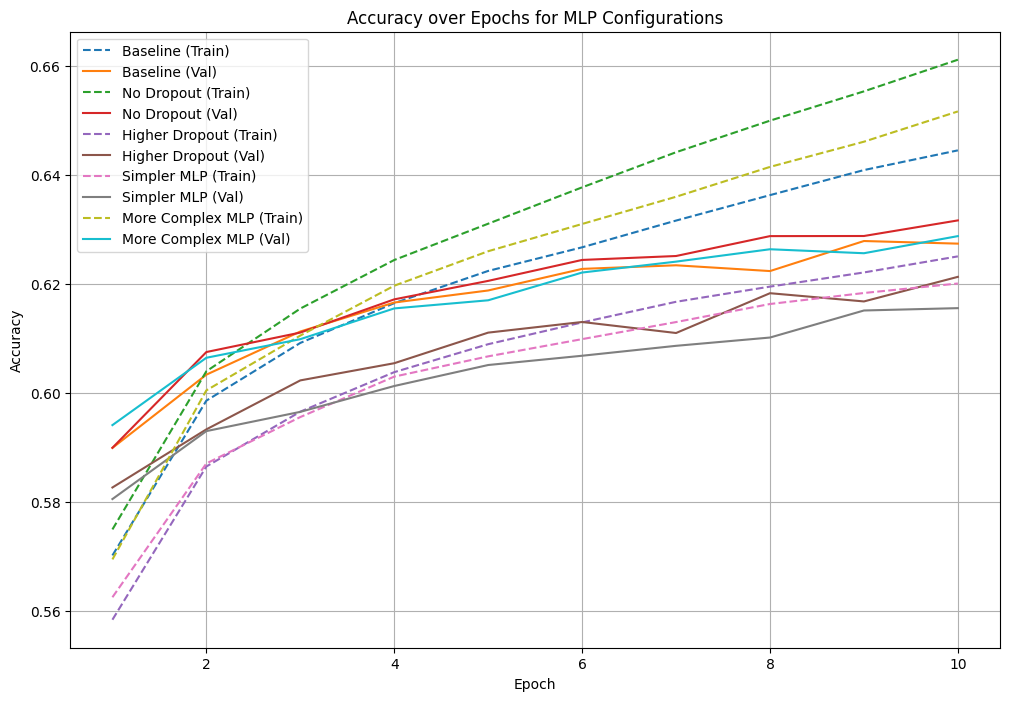

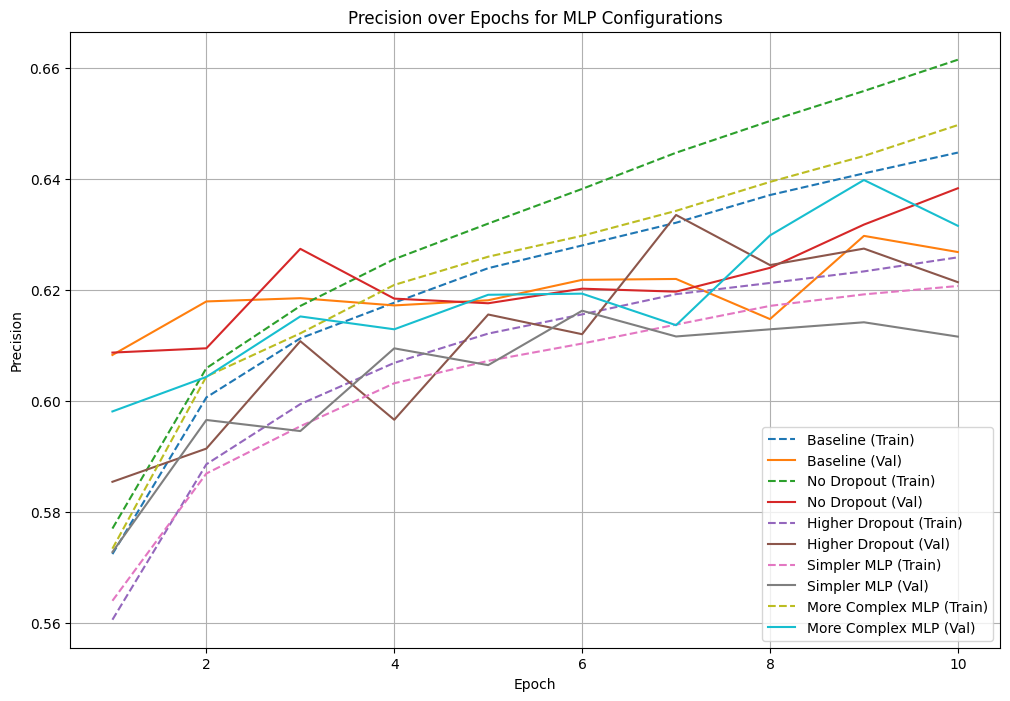

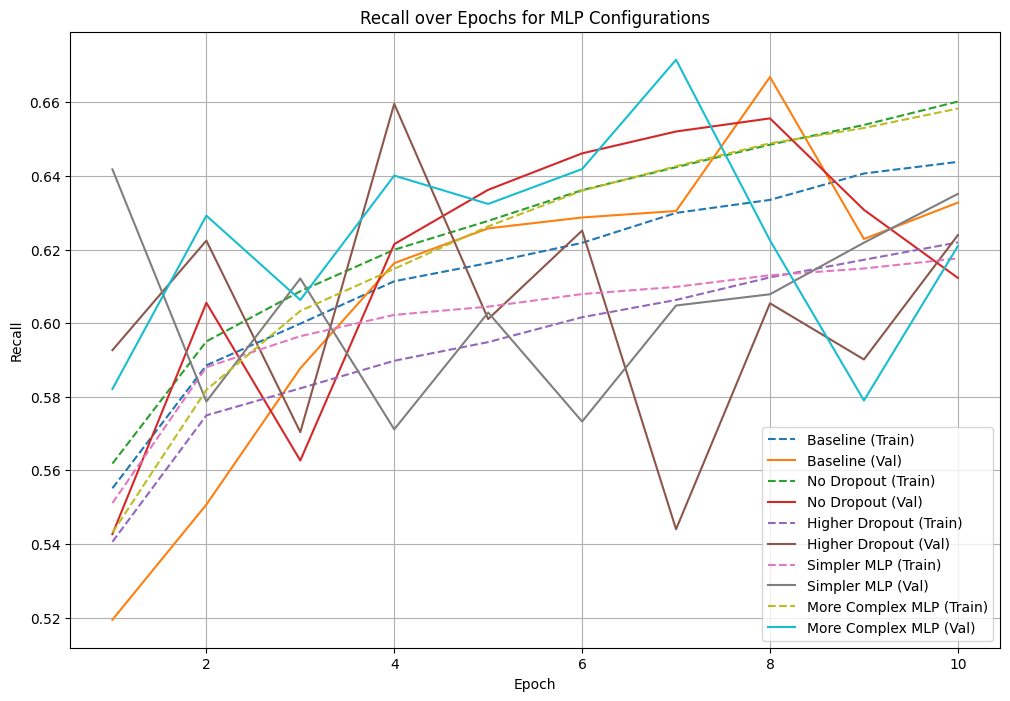

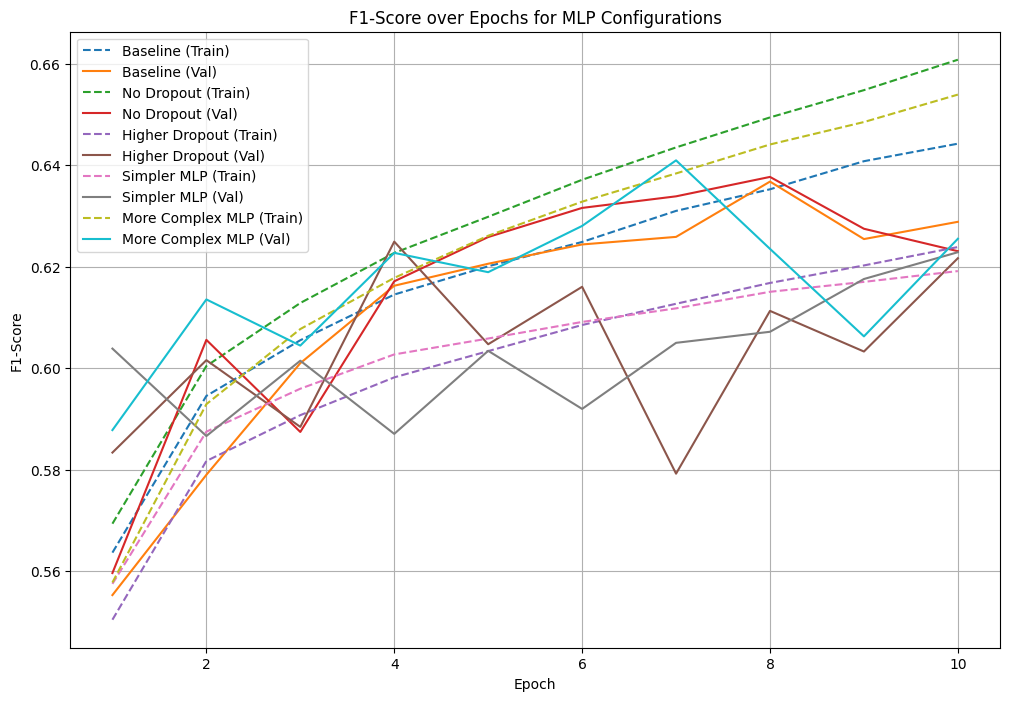

In [32]:
# Learning Curves for MLP Configurations
metrics_to_plot = ['accuracies', 'precisions', 'recalls', 'f1s']
titles = ['Accuracy', 'Precision', 'Recall', 'F1-Score']

for metric, title in zip(metrics_to_plot, titles):
    plt.figure(figsize=(12, 8))
    for name, metrics in all_config_metrics.items():
        plt.plot(range(1, epochs+1), metrics[f'train_{metric}'], label=f"{name} (Train)", linestyle='--')
        plt.plot(range(1, epochs+1), metrics[f'eval_{metric}'], label=f"{name} (Val)")
    plt.xlabel("Epoch")
    plt.ylabel(title)
    plt.title(f"{title} over Epochs for MLP Configurations")
    plt.legend()
    plt.grid(True)
    plt.show()

In [33]:
mlp_metrics = {
    name: {
        'eval_accuracies': metrics['eval_accuracies'][-1],
        'eval_precisions': metrics['eval_precisions'][-1],
        'eval_recalls': metrics['eval_recalls'][-1],
        'eval_f1s': metrics['eval_f1s'][-1],
        'eval_auc': metrics['eval_auc'][-1]
    } for name, metrics in all_config_metrics.items()
}

## Scikit-Learn Models

In [ ]:
scorers = {
    'accuracy': 'accuracy',
    'precision': make_scorer(precision_score, zero_division=0),
    'recall': make_scorer(recall_score, zero_division=0),
    'f1': make_scorer(f1_score, zero_division=0),
    'roc_auc': 'roc_auc'
}

# Extract embeddings and labels 
X = data_set.embeddings.numpy()
y = data_set.labels.numpy()

# Define scikit-learn models
models = {
    "Logistic Regression": make_pipeline(StandardScaler(), LogisticRegression(max_iter=1000, random_state=42)),
    "Gaussian Naive Bayes": make_pipeline(StandardScaler(), GaussianNB()),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1),
    "Gradient Boosting": GradientBoostingClassifier(n_estimators=100, random_state=42)
}

scikit_results = {}

# Evaluate models using custom_cross_validate
for name, model in models.items():
    print(f"\nEvaluating {name} with 5-fold CV...")
    scores = cross_validate(model, X, y, cv=5, scoring=scorers, return_train_score=True, n_jobs=-1)
    
    # Store mean training and validation metrics
    scikit_results[name] = {
        'train_accuracy': np.mean(scores['train_accuracy']),
        'train_precision': np.mean(scores['train_precision']),
        'train_recall': np.mean(scores['train_recall']),
        'train_f1': np.mean(scores['train_f1']),
        'train_roc_auc': np.mean(scores['train_roc_auc']),
        'eval_accuracy': np.mean(scores['test_accuracy']),
        'eval_precision': np.mean(scores['test_precision']),
        'eval_recall': np.mean(scores['test_recall']),
        'eval_f1': np.mean(scores['test_f1']),
        'eval_roc_auc': np.mean(scores['test_roc_auc'])
    }


Evaluating Logistic Regression with 5-fold CV...



Evaluating Gaussian Naive Bayes with 5-fold CV...

Evaluating Random Forest with 5-fold CV...

Evaluating Gradient Boosting with 5-fold CV...


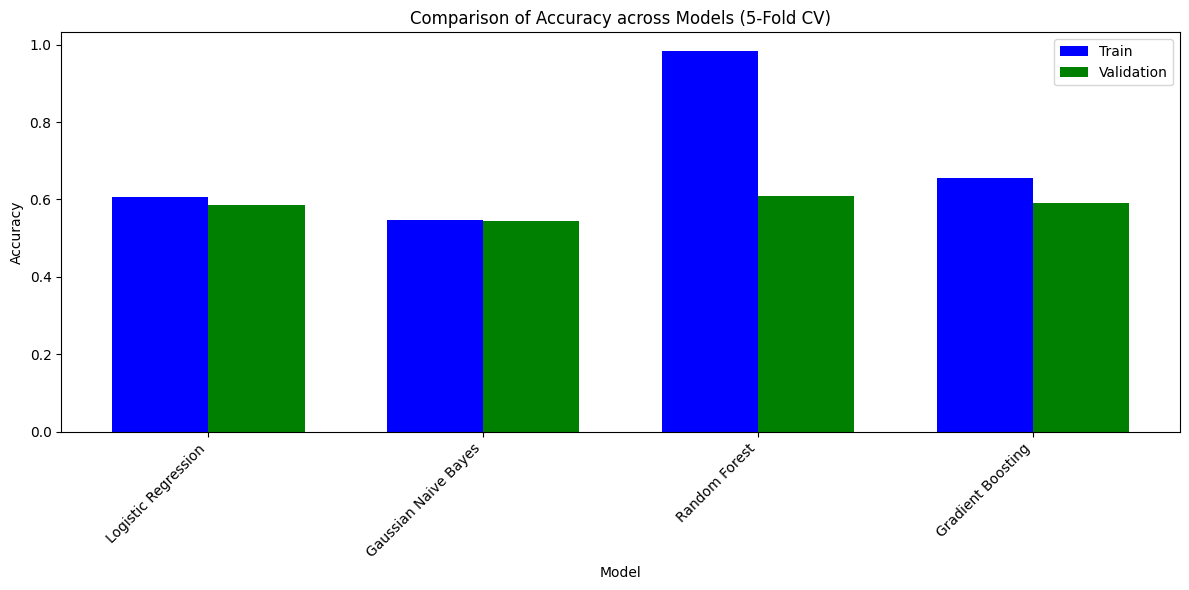

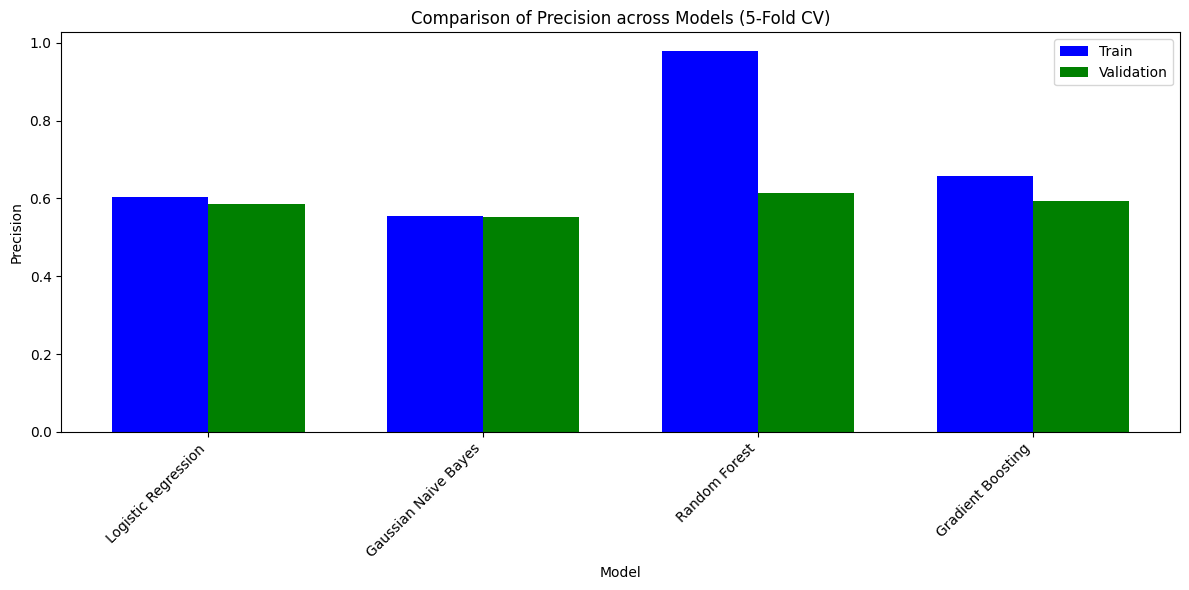

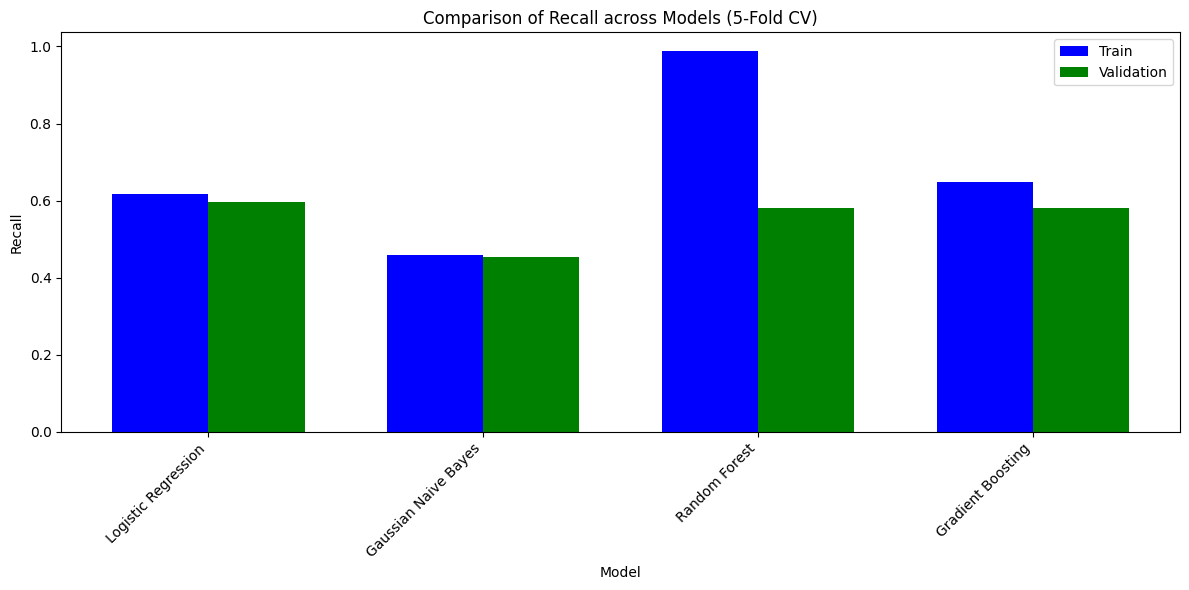

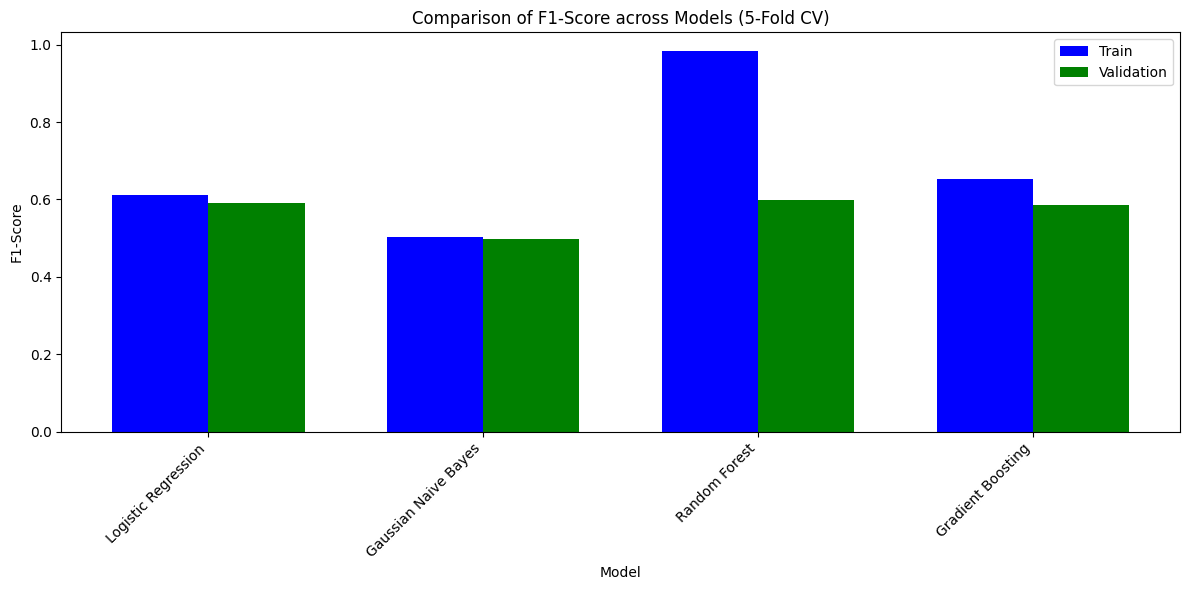

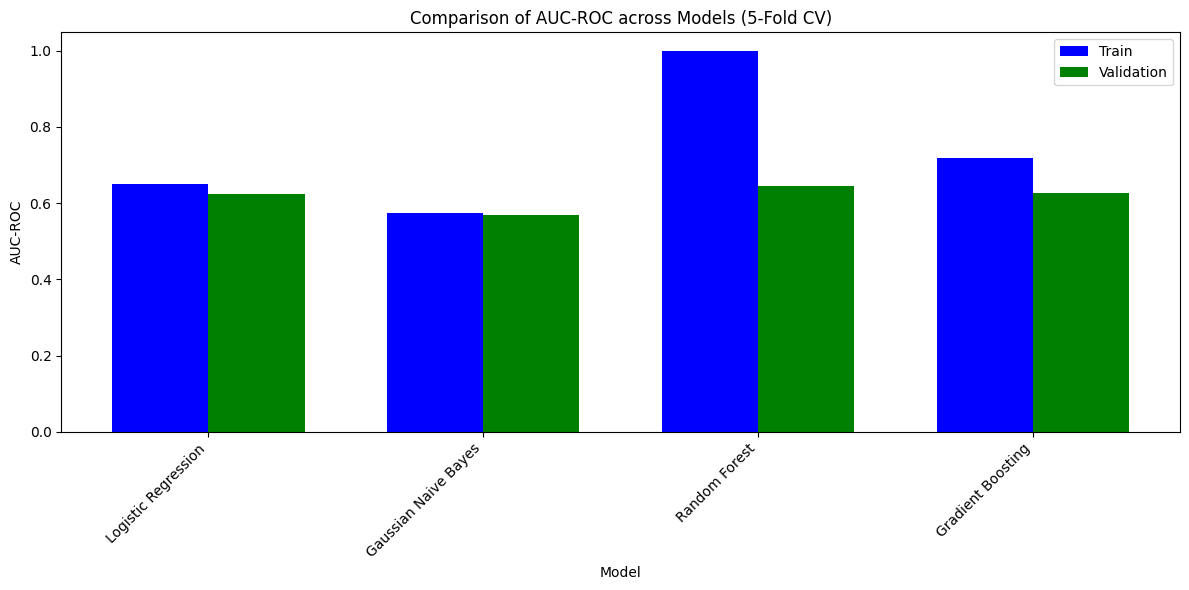

In [ ]:
# Visualization
metrics_to_plot = ['accuracy', 'precision', 'recall', 'f1', 'roc_auc']
titles = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'AUC-ROC']

for metric, title in zip(metrics_to_plot, titles):
    plt.figure(figsize=(12, 6))
    train_values = [scikit_results[name][f'train_{metric}'] for name in models.keys()]
    eval_values = [scikit_results[name][f'eval_{metric}'] for name in models.keys()]
    model_names = list(models.keys())
    
    x = np.arange(len(model_names))
    width = 0.35
    plt.bar(x - width/2, train_values, width, label='Train', color='blue')
    plt.bar(x + width/2, eval_values, width, label='Validation', color='green')
    plt.xlabel("Model")
    plt.ylabel(title)
    plt.title(f"Comparison of {title} across Models (5-Fold CV)")
    plt.xticks(x, model_names, rotation=45, ha='right')
    plt.legend()
    plt.tight_layout()
    plt.show()